In [5]:
import pandas as pd
import re
import numpy as np
import folium
import xml.etree.ElementTree as ET
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pdfminer.high_level import extract_text
from urllib.request import urlopen
from bs4 import BeautifulSoup
from math import sin, cos, sqrt, atan2, radians, asin, degrees, ceil
from scipy.spatial import KDTree
from urllib.request import urlopen
import time
import random
from datetime import datetime as dt, time as t, timedelta as td
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import math

1. https://docs.python.org/3/library/xml.etree.elementtree.html


## Combine json and xml

In [6]:
df_sample = pd.read_csv('sample_output.csv')

In [7]:
df_json = pd.read_json('33366829.json')

In [8]:
# read xml file
with open('33366829.xml', 'r') as file:
    xml_text = file.read()
    xml_text = '<root>' + xml_text + '</root>'
    #replace & with '&amp;'
    xml_text = xml_text.replace('&', '&amp;')
    # pase text to xml object
    xml = ET.fromstring(xml_text)

In [9]:
# list for keeping data
xml_list = []

# create a new element element 
for element in xml:
    element_dict = {}
    prop_id = element.find('property_id').text
    lat = element.find('lat').text
    lng = element.find('lng').text
    addr_street = element.find('addr_street').text
    element_dict = {"property_id": prop_id,
                   "lat": lat,
                   "lng": lng,
                   "addr_street": addr_street}
    xml_list.append(element_dict)

In [10]:
df_xml = pd.DataFrame(xml_list)

In [11]:
# chceck data type of json
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   property_id  1093 non-null   int64  
 1   lat          1093 non-null   float64
 2   lng          1093 non-null   float64
 3   addr_street  1093 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 34.3+ KB


In [12]:
# check data type of xml
df_xml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  1089 non-null   object
 1   lat          1089 non-null   object
 2   lng          1089 non-null   object
 3   addr_street  1089 non-null   object
dtypes: object(4)
memory usage: 34.2+ KB


In [13]:
# change data type to be same as sample output
df_xml['property_id'] = df_xml['property_id'].astype('int64')
df_xml['lat'] = df_xml['lat'].astype('float64')
df_xml['lng'] = df_xml['lng'].astype('float64')

In [14]:
# concat data frame
combined_df = pd.concat([df_json, df_xml], axis=0)

In [15]:
# replace xml tag '&amp' from previous with '&'
combined_df['addr_street'] = combined_df['addr_street'].apply(lambda x: x.replace('&amp;', '&'))

In [16]:
# check duplicate 
combined_df.loc[combined_df.duplicated(keep= False)]

property_id        lat         lng          addr_street
1           17262 -37.712075  144.937175       43 West Street
2           86201 -37.893024  144.993133    16 Harwood Street
3            2097 -37.785782  144.883397     29 Rosamond Road
4           80903 -37.981124  145.223624      18 Grace Avenue
82          68219 -37.836693  145.018078       8 Ultimo Court
95          84064 -37.849194  144.988968    47 Charles Street
160         68541 -37.857982  145.019045  44a Armadale Street
181         20883 -37.757915  144.951964       25 Rose Street
190         68541 -37.857982  145.019045  44a Armadale Street
196         64791 -37.793937  145.295743     7 ALLENDALE ROAD
253         62651 -37.832817  145.238556      1a Sunset Drive
268         85389 -37.879993  145.012530       21 Park Street
270          9498 -37.861240  144.726248     35 Cheviot Drive
315         63509 -37.788488  145.285921      13 William Road
320         77729 -37.925783  145.176386     21 Sunrise Drive
366         64791 -37.793937  145.295743     7 ALLENDALE ROAD
376         68219 -37.836693  145.018078       8 Ultimo Court
394         84064 -37.849194  144.988968    47 Charles Street
486         48064 -37.804632  145.049557   2/33 Parkhill Road
547         93074 -38.022604  145.104367       26 Glen Street
563         77729 -37.925783  145.176386     21 Sunrise Drive
619         65430 -37.807678  145.314378    54 Liverpool Road
773         12941 -37.712248  144.774865     30 Blackwood Way
797         12941 -37.712248  144.774865     30 Blackwood Way
860         20883 -37.757915  144.951964       25 Rose Street
906          9498 -37.861240  144.726248     35 Cheviot Drive
935         65430 -37.807678  145.314378    54 Liverpool Road
1001        62651 -37.832817  145.238556      1a Sunset Drive
1058        48064 -37.804632  145.049557   2/33 Parkhill Road
229         63509 -37.788488  145.285921      13 William Road
231         80927 -37.972830  145.220688         19 Ingrid St
398         88273 -37.941910  145.042480      7 Hillston Road
440         85389 -37.879993  145.012530       21 Park Street
492          5646 -37.788932  144.859924   23 Crothers Street
493         80927 -37.972830  145.220688         19 Ingrid St
743         88273 -37.941910  145.042480      7 Hillston Road
771          5646 -37.788932  144.859924   23 Crothers Street
787         63993 -37.791891  145.278242    23/35 Kent Avenue
885         63993 -37.791891  145.278242    23/35 Kent Avenue
934         93074 -38.022604  145.104367       26 Glen Street
1085        17262 -37.712075  144.937175       43 West Street
1086        86201 -37.893024  144.993133    16 Harwood Street
1087         2097 -37.785782  144.883397     29 Rosamond Road
1088        80903 -37.981124  145.223624      18 Grace Avenue

In [17]:
# delete duplicate
combined_df = combined_df.drop_duplicates()

In [18]:
# read vic_suburb_boundary
gdf = gpd.read_file('Vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp')
gdf = gdf[['VIC_LOCA_2', 'geometry']]

In [19]:
# convert lat and lng to point 
points = gpd.GeoDataFrame(combined_df, geometry=gpd.points_from_xy(combined_df.lng, combined_df.lat, crs='EPSG:4283'))

In [20]:
combined_df = gpd.sjoin(points, gdf, how='left', op='within')

C:\Users\non_n\conda\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [21]:
# drop index_right
combined_df = combined_df.drop('index_right', axis=1)
combined_df = combined_df.rename(columns={'VIC_LOCA_2':'suburb'})

In [22]:
# read data from Lga_to_suburb.pdf
pdf_text = extract_text('Lga_to_suburb.pdf')

In [23]:
# extract lga
lga_pattern = re.compile(r"[A-Z]+ : \[[\w', ]+\]")
lga_match = lga_pattern.findall(pdf_text)

In [24]:
suburb_dict = {}
for match in lga_match:
    lga, suburb = match.split(':')
    lga = lga.strip()
    suburb = suburb.strip().strip('[]')
    suburb_list = [suburb.strip().strip("'") for suburb in suburb.split(',')]
    
    suburb_dict[lga] = suburb_list

In [25]:
# transform suburb_dict, prepare for crate data frame
suburb_trans_list = []

for key, value_list in suburb_dict.items():
    for value in value_list:
        suburb_trans_dict = {
             'suburb' : value.upper(),
                'lga' : key 
            }
        suburb_trans_list.append(suburb_trans_dict)

In [26]:
suburb_lga_df = pd.DataFrame(suburb_trans_list)

In [27]:
combined_df = pd.merge(combined_df, suburb_lga_df, on='suburb')

In [28]:
# Create closet train station
station_df = pd.read_csv('Vic_GTFS_data\metropolitan\stops.txt')

In [29]:
combined_df = combined_df.drop('geometry', axis=1)

In [30]:
combined_df

property_id        lat         lng             addr_street  \
0           82622 -37.911752  145.272935              19 Adam Cl   
1           82892 -37.902584  145.266543       8 Albatross Drive   
2           82865 -37.905153  145.278999        7 Boradino Place   
3           82645 -37.909080  145.252822      2 Valleyview Drive   
4           82814 -37.909597  145.251462     50 Bexsarm Crescent   
...           ...        ...         ...                     ...   
1982        39123 -37.751744  145.037772   12 Skeffington Street   
1983         9449 -37.855813  144.738262   28 Wetlands Boulevard   
1984        16078 -37.704721  144.879609  4/40 Broadmeadows Road   
1985        74114 -37.913245  145.279108      12 Jindabyne Court   
1986        76164 -37.905952  145.105331       4 Greville Street   

                suburb         lga  
0             ROWVILLE    BALLARAT  
1             ROWVILLE    BALLARAT  
2             ROWVILLE    BALLARAT  
3             ROWVILLE    BALLARAT  
4             ROWVILLE    BALLARAT  
...                ...         ...  
1982         BELLFIELD    MITCHELL  
1983  WILLIAMS LANDING      LODDON  
1984       TULLAMARINE  GOLDFIELDS  
1985       LYSTERFIELD    BALLARAT  
1986       HUNTINGDALE   DANDENONG  

[1987 rows x 6 columns]

In [31]:
# Calculate distance using Haversine formula
def get_dist(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6378
    km = round(6378 * c, 5)

    return km

In [32]:
tree = KDTree(station_df[['stop_lat', 'stop_lon']])

In [33]:
# Find nearest station for each house using KDtree structure
# distances is closet distance, indicies is index of closet station
distances, indices = tree.query(combined_df[['lat', 'lng']], k=1)

In [36]:
distances

array([0.03743339, 0.03550196, 0.02853547, ..., 0.03748893, 0.03508677,
       0.00586998])

In [34]:
indices

array([ 43,  43,  43, ..., 198,  42,  91], dtype=int64)

In [35]:
indices.flatten()

array([ 43,  43,  43, ..., 198,  42,  91], dtype=int64)

In [37]:
# Convert distances to kilometers
closest_distances_km = np.vectorize(get_dist)(combined_df['lat'], combined_df['lng'],
                                              station_df.iloc[indices]['stop_lat'],
                                              station_df.iloc[indices]['stop_lon'])

In [38]:
station_df

stop_id                         stop_name   stop_short_name   stop_lat  \
0      15351           Sunbury Railway Station           Sunbury -37.579091   
1      15353      Diggers Rest Railway Station      Diggers Rest -37.627017   
2      19827       Stony Point Railway Station        Crib Point -38.374235   
3      19828        Crib Point Railway Station        Crib Point -38.366123   
4      19829          Morradoo Railway Station        Crib Point -38.354033   
..       ...                               ...               ...        ...   
213    44817          Coolaroo Railway Station          Coolaroo -37.661003   
214    45793          Lynbrook Railway Station          Lynbrook -38.057341   
215    45794     Cardinia Road Railway Station          Pakenham -38.071290   
216    45795      South Morang Railway Station      South Morang -37.649159   
217    46468  Williams Landing Railway Station  Williams Landing -37.869865   

       stop_lon  
0    144.727319  
1    144.719922  
2    145.221837  
3    145.204043  
4    145.189602  
..          ...  
213  144.926056  
214  145.249275  
215  145.437791  
216  145.067032  
217  144.747445  

[218 rows x 5 columns]

In [ ]:
closest_station = station_df.iloc[indices].drop(['stop_name', 'stop_short_name', 'stop_lat', 'stop_lon'], axis=1)

In [ ]:
closest_station = closest_station.reset_index(drop=True)

In [ ]:
# Add closest station ID and distance (in km) to house data frame
combined_df['distance_to_closest_train_station'] = closest_distances_km

In [ ]:
combined_df = pd.concat([combined_df, closest_station], axis=1)

In [ ]:
combined_df = combined_df.rename(columns={'stop_id':'closest_train_station_id'})

## Web scraping

In [ ]:
# find unique suburb
suburb_list= list(combined_df['suburb'].unique())

In [ ]:
# regex patterns
house_unit_pattern = re.compile(r"(?<=Number of houses\/units)(.+)(?=Houses\/units sales last 12 months)")
pop_num_pattern = re.compile(r"(?<=All People)\n(\d+)")
aus_born_pattern = re.compile(r"(?<=Australian Born)\n(\d{2}%)")
median_income_pattern = re.compile(r"(?<=Weekly income)\n(\$\d?,?\d{3})")
median_house_pattern = re.compile(r"(?<=House)\n(\$\d{1,2}?,?\d{2,3},\d{3})")

In [ ]:
suburb_list_1 = suburb_list[0:39]
suburb_list_2 = suburb_list[39:79]
suburb_list_3 = suburb_list[79:119]
suburb_list_4 = suburb_list[119:]

In [ ]:
sub_info_list = []

In [ ]:
def web_scraping(sub_list, info_list):
    
    # create url for each suburb
    for suburb in sub_list:
        suburb_info_dict = {"suburb": None,
                            "number_of_houses":None,
                            "number_of_units":None,
                            "municipality":None,
                            "population":None,
                            "aus_born_perc":None,
                            "median_income":None,
                            "median_house_price":None
                           }

        sub_url = f"http://house.speakingsame.com/profile.php?q={suburb}&sta=vic"
        sub_url = sub_url.replace(" ", "%20")
        html = urlopen(sub_url).read()
        time.sleep(1)


        html_text = html.decode('utf-8')
        soup = BeautifulSoup(html_text, "lxml")

        tags_a = soup.find_all('a')
        tags_table = soup.find_all("td")

        # find munipalcity
        for tag_a in tags_a:
            if "city.php?" in tag_a['href']:
                suburb_info_dict["suburb"] = suburb
                suburb_info_dict["municipality"] = tag_a.text
                print(suburb)
                print(tag_a.text)
                print("--------------------------------------------------------------")

        tag_a_text = ""
        for table in tags_table:
            tag_a_text += "\n" + table.text

        house_unit_match = house_unit_pattern.findall(tag_a_text)[0].split("/")
        house_number = house_unit_match[0]
        unit_number = house_unit_match[1]

        pop_num_match = pop_num_pattern.findall(tag_a_text)[0]
        aus_born_match= aus_born_pattern.findall(tag_a_text)[0]
        median_income_match = median_income_pattern.findall(tag_a_text)[0]
        median_house_match = median_house_pattern.findall(tag_a_text)[0]

        suburb_info_dict["number_of_houses"] = house_number
        suburb_info_dict["number_of_units"] = unit_number
        suburb_info_dict["population"] = pop_num_match
        suburb_info_dict["aus_born_perc"] = aus_born_match
        suburb_info_dict["median_income"] = median_income_match
        suburb_info_dict["median_house_price"] = median_house_match

        print(f"House number match: {house_number}")
        print(f"Unit number match: {unit_number}")
        print(f"Population number: {pop_num_match}")
        print(f"Australian bourn per: {aus_born_match}")
        print(f"Median income: {median_income_match}")
        print(f"Median house price: {median_house_match}")
        print("--------------------------------------------------------------")
        
        info_list.append(suburb_info_dict)

In [ ]:
web_scraping(sub_list=suburb_list_1, info_list=sub_info_list)
time.sleep(600)

In [ ]:
web_scraping(sub_list=suburb_list_2, info_list=sub_info_list)
time.sleep(600)

In [ ]:
web_scraping(sub_list=suburb_list_3, info_list=sub_info_list)
time.sleep(600)

In [ ]:
web_scraping(sub_list=suburb_list_4, info_list=sub_info_list)

In [ ]:
len(sub_info_list)

In [ ]:
web_df = pd.DataFrame(sub_info_list)

In [ ]:
web_df.to_csv('web_scraping_result')

In [ ]:
combined_df = pd.merge(combined_df, web_df, how='left', on='suburb')

In [ ]:
combined_df

## find direct_journey_flag and travel_min_to_MC

In [ ]:
# read all necessary file
route_df = pd.read_csv(r"Vic_GTFS_data\metropolitan\routes.txt")
trip_df = pd.read_csv(r"Vic_GTFS_data\metropolitan\trips.txt")
stop_time = pd.read_csv(r"Vic_GTFS_data\metropolitan\stop_times.txt")
calendar = pd.read_csv(r"Vic_GTFS_data\metropolitan\calendar.txt")
stops = pd.read_csv(r"Vic_GTFS_data\metropolitan\stops.txt")
shapes_df = pd.read_csv(r"Vic_GTFS_data\metropolitan\shapes.txt")

In [ ]:
stop_time.loc[stop_time['departure_time'] == '25:07:00']

In [ ]:
# Melbourne central is called Melbourne Central Railway Station
mbc_id = int(stops.loc[stops['stop_name'] == 'Melbourne Central Railway Station', 'stop_id'])

In [ ]:
def avg_min(closest_station_id, destination_id, stop_time, trip_df, calendar):
    # use closet_station_id to find data in stop_time
    closest_station_trip = stop_time.loc[stop_time['stop_id'] == closest_station_id]
    destination_trip = stop_time.loc[stop_time['stop_id'] == destination_id]
    
    combined_trip = pd.merge(closest_station_trip, destination_trip, on="trip_id", how="inner")
    combined_trip = combined_trip[['trip_id', 'departure_time_x', 'arrival_time_y']]
    
    def fix_24(time):
        if time[0:2] == "24":
            time = "00" + time[2:]
            return time
        elif time[0:2] == '25':
            time = "01" + time[2:]
            return time
        else:
            return time
    
    combined_trip['departure_time_x'] = combined_trip['departure_time_x'].apply(fix_24)
    combined_trip['arrival_time_y'] = combined_trip['arrival_time_y'].apply(fix_24)
    combined_trip['departure_time_x'] = combined_trip['departure_time_x'].apply(lambda x: dt.strptime(x, "%H:%M:%S").time())
    combined_trip['arrival_time_y'] = combined_trip['arrival_time_y'].apply(lambda x: dt.strptime(x, "%H:%M:%S").time())
        
    # set time interval
    start =  dt.strptime("07:00:00","%H:%M:%S").time()
    end = dt.strptime("09:00:00","%H:%M:%S").time()
    
    # filter row that not in interval
    combined_trip = combined_trip.loc[combined_trip['departure_time_x'].between(start, end)]
    combined_trip = combined_trip.loc[combined_trip['arrival_time_y'].between(start, end)]
    
    # keep only the trip haeding to mcb
    combined_trip = combined_trip.loc[combined_trip['arrival_time_y'] > combined_trip['departure_time_x']]
    
    
    # merge with trip_df because we need service_id, direction_id 
    combined_trip = pd.merge(combined_trip, trip_df, how="left", on="trip_id")
    
    # keep only needed info
    combined_trip = combined_trip[['trip_id', 'departure_time_x', 'arrival_time_y', 'route_id', 'service_id', 'direction_id']]
    
    # merge with calaendar 
    combined_trip = pd.merge(combined_trip, calendar.drop(['start_date', 'end_date', 'saturday', 'sunday'], axis=1), how='left', on= 'service_id')
    
    # keep only the trips that operate on week days
    combined_trip = combined_trip.loc[(combined_trip['monday'] == 1)&(combined_trip['tuesday'] == 1)&(combined_trip['wednesday'] == 1)&(combined_trip['thursday'] == 1)&(combined_trip['friday'] == 1) ]
    
    # change time object to time delta, prepare for time comparing
    combined_trip['departure_time_x_min'] = combined_trip['departure_time_x'].apply(lambda x: td(hours=x.hour, minutes=x.minute, seconds=x.second))
    combined_trip['arrival_time_y_min'] = combined_trip['arrival_time_y'].apply(lambda x: td(hours=x.hour, minutes=x.minute, seconds=x.second))
    
    # create new col to keep time diff
    combined_trip['time_diff'] = abs(combined_trip['departure_time_x_min'] - combined_trip['arrival_time_y_min'])
    # chang it to min
    combined_trip['time_diff'] = combined_trip['time_diff'].apply(lambda x: x.total_seconds()/60)
    
    # check if there is direct trip
    if len(combined_trip) != 0:
        average_min = sum(combined_trip['time_diff'])/ len(combined_trip['trip_id'])
        return round(average_min)
    else:
        return 'no direct trip is available'

In [ ]:
 station_id_df = stops[['stop_id']].drop_duplicates()

In [ ]:
 station_id_df['travel_min_to_MC'] =  station_id_df['stop_id'].apply(lambda x: avg_min(x, mbc_id, stop_time, trip_df, calendar))

In [ ]:
station_id_df = station_id_df.rename({'stop_id': 'closest_train_station_id'}, axis=1)

In [ ]:
check = {'closest_train_station_id': [20021, 19984, 19967, 19900, 19914, 19948, 20000, 20006, 19892, 40220, 19897, 19876, 19913, 19872, 19898]}

In [ ]:
check_df = pd.DataFrame(check)

In [ ]:
check_df = pd.merge(check_df, station_id_df, how='left', on='closest_train_station_id')

In [ ]:
check_df

In [ ]:
# merge combined_df and station_id_df
combined_df = pd.merge(combined_df, station_id_df, how='left', on='closest_train_station_id')

In [ ]:
# create direct_journey_flag
combined_df['direct_journey_flag'] = combined_df.apply(lambda x: 0 if x['travel_min_to_MC'] == 'no direct trip is available' else 1, axis=1)

In [ ]:
correct_order_list = ['property_id', 'lat', 'lng', 'addr_street', 'suburb', 'number_of_houses', 'number_of_units', 'municipality', 'population', 'aus_born_perc', 'median_income', 'median_house_price', 'lga', 'closest_train_station_id', 'distance_to_closest_train_station', 'travel_min_to_MC', 'direct_journey_flag']

In [ ]:
# Rearrange columns
combined_df = combined_df[correct_order_list]

In [ ]:
# Remove all possible spaces from start and end of each cell
object_list = ['addr_street', 'suburb', 'number_of_houses', 'number_of_units', 'municipality', 'population', 'aus_born_perc', 'median_income', 'median_house_price', 'lga']
combined_df[object_list] = combined_df[object_list].astype(str).apply(lambda x: x.str.strip())

In [ ]:
combined_df.loc[combined_df['number_of_units'] == '4021Houses', 'number_of_units'] = combined_df.loc[combined_df['number_of_units'] == '4021Houses', 'number_of_units'].apply(lambda x: x[0:3])

In [ ]:
combined_df = combined_df.astype(df_sample.dtypes)

In [ ]:
combined_df.to_csv('33366829_A3_solution.csv')

## Task 2

In [190]:
combined_df = pd.read_csv('33366829_A3_solution.csv')

In [191]:
# keep only necessary columns
df = combined_df[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income', 'median_house_price']]

In [192]:
# change aus_bourn_perc to float
df['aus_born_perc'] = df['aus_born_perc'].str.strip('%').astype('float64')/100


C:\Users\non_n\AppData\Local\Temp\ipykernel_30196\556408222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aus_born_perc'] = df['aus_born_perc'].str.strip('%').astype('float64')/100


In [193]:
# change median_income and median_house_price to number
df['median_income'] = df['median_income'].str.strip('$').str.replace(',', '').astype('float64')
df['median_house_price'] = df['median_house_price'].str.strip('$').str.replace(',', '').astype('float64')


C:\Users\non_n\AppData\Local\Temp\ipykernel_30196\2394225237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['median_income'] = df['median_income'].str.strip('$').str.replace(',', '').astype('float64')
C:\Users\non_n\AppData\Local\Temp\ipykernel_30196\2394225237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['median_house_price'] = df['median_house_price'].str.strip('$').str.replace(',', '').astype('float64')


### Data normalization

In [107]:
df.describe()

number_of_houses  number_of_units    population  aus_born_perc  \
count       1987.000000      1987.000000   1987.000000    1987.000000   
mean        5879.535984      3388.467539  20404.316558       0.686814   
std         3476.167919      2851.009813   8964.633718       0.103009   
min          363.000000        60.000000    170.000000       0.360000   
25%         3150.000000      1307.500000  13849.000000       0.630000   
50%         5052.000000      2524.000000  19624.000000       0.700000   
75%         8074.000000      4557.000000  26045.000000       0.770000   
max        16913.000000     16139.000000  54005.000000       0.870000   

       median_income  median_house_price  
count    1987.000000        1.987000e+03  
mean     1373.248616        1.221808e+06  
std       317.850170        4.827719e+05  
min       633.000000        5.072000e+05  
25%      1180.000000        8.872000e+05  
50%      1360.000000        1.124800e+06  
75%      1551.000000        1.438700e+06  
max      2352.000000        2.733900e+06

We can see from the above talbe that all columns are all in different scales range from 0.36 to 2.734e+06. which will affect when we are modeling.

#### Z-Score Normalization

In [194]:
z_nor_df = df.copy()

In [195]:
std_scale = preprocessing.StandardScaler().fit(df[list(df.columns)])
df_std = std_scale.transform(df[list(df.columns)])

In [196]:
z_nor_df['nh_scaled'] = df_std[:, 0]
z_nor_df['nu_scaled'] = df_std[:, 1]
z_nor_df['pop_scaled'] = df_std[:, 2]
z_nor_df['ab_scaled'] = df_std[:, 3]
z_nor_df['mi_scaled'] = df_std[:, 4]
z_nor_df['mhp_scaled'] = df_std[:, 5]

In [111]:
z_nor_df

number_of_houses  number_of_units  population  aus_born_perc  \
0               9231.0           1496.0     28725.0           0.71   
1               9231.0           1496.0     28725.0           0.71   
2               9231.0           1496.0     28725.0           0.71   
3               9231.0           1496.0     28725.0           0.71   
4               9231.0           1496.0     28725.0           0.71   
...                ...              ...         ...            ...   
1982             738.0            119.0     13096.0           0.74   
1983            2735.0            173.0       170.0           0.87   
1984            3164.0           2016.0     16710.0           0.65   
1985            1797.0             79.0     35341.0           0.78   
1986             751.0            342.0     16280.0           0.65   

      median_income  median_house_price  nh_scaled  nu_scaled  pop_scaled  \
0            1699.0           1074900.0   0.964369  -0.663956    0.928401   
1            1699.0           1074900.0   0.964369  -0.663956    0.928401   
2            1699.0           1074900.0   0.964369  -0.663956    0.928401   
3            1699.0           1074900.0   0.964369  -0.663956    0.928401   
4            1699.0           1074900.0   0.964369  -0.663956    0.928401   
...             ...                 ...        ...        ...         ...   
1982          938.0            994800.0  -1.479454  -1.147064   -0.815444   
1983         1842.0            861100.0  -0.904826  -1.128119   -2.257695   
1984         1150.0            706000.0  -0.781383  -0.481518   -0.412203   
1985         1392.0           1386000.0  -1.174731  -1.161098    1.666598   
1986         1340.0           1192500.0  -1.475713  -1.068826   -0.460181   

      ab_scaled  mi_scaled  mhp_scaled  
0      0.225141   1.025116   -0.304378  
1      0.225141   1.025116   -0.304378  
2      0.225141   1.025116   -0.304378  
3      0.225141   1.025116   -0.304378  
4      0.225141   1.025116   -0.304378  
...         ...        ...         ...  
1982   0.516451  -1.369696   -0.470336  
1983   1.778795   1.475127   -0.747348  
1984  -0.357479  -0.702547   -1.068699  
1985   0.904865   0.059009    0.340188  
1986  -0.357479  -0.104631   -0.060723  

[1987 rows x 12 columns]

#### ploting before and after sclaing

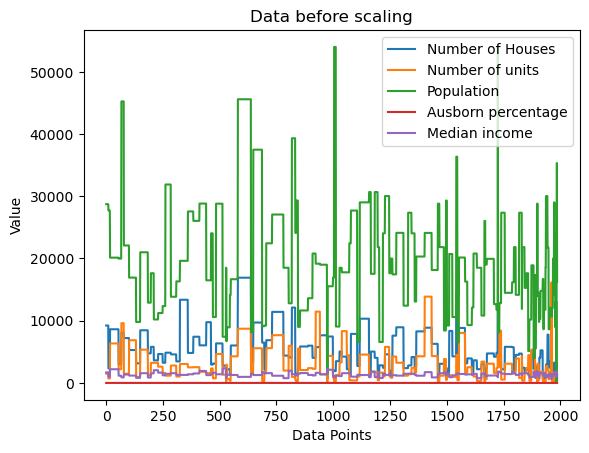

In [112]:
# before 
z_nor_df['number_of_houses'].plot(label='Number of Houses')
z_nor_df['number_of_units'].plot(label='Number of units')
z_nor_df['population'].plot(label='Population')
z_nor_df['aus_born_perc'].plot(label='Ausborn percentage')
z_nor_df['median_income'].plot(label='Median income')
# z_nor_df['median_house_price'].plot(label='Median house price')

# x, y axes
plt.xlabel('Data Points')
plt.ylabel('Value')
plt.title('Data before scaling')

# Add legend
plt.legend()

From the first plot, before scaling. We can clearly see that the scales are highly variated, if we use these data to model the median_house_price, the model might not effectively predict the medeian_house_price.

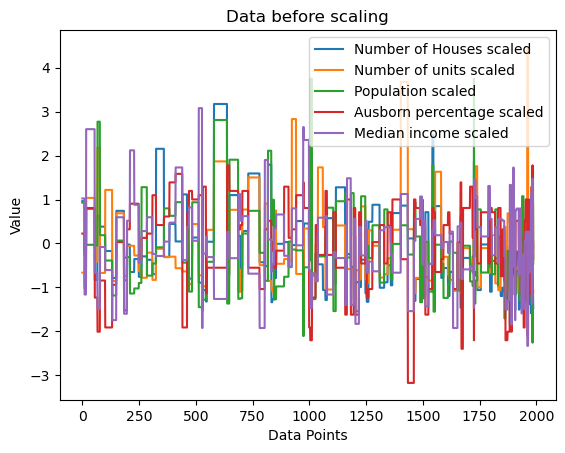

In [113]:
# after scaling 
z_nor_df['nh_scaled'].plot(label='Number of Houses scaled')
z_nor_df['nu_scaled'].plot(label='Number of units scaled')
z_nor_df['pop_scaled'].plot(label='Population scaled')
z_nor_df['ab_scaled'].plot(label='Ausborn percentage scaled')
z_nor_df['mi_scaled'].plot(label='Median income scaled')
# z_nor_df['mhp_scaled'].plot()
                     
                     
# x, y axes
plt.xlabel('Data Points')
plt.ylabel('Value')
plt.title('Data before scaling')

# Add legend
plt.legend()

After scaling, we can see that all the features' value ranges are much narrow from before.

In [114]:
z_nor_df.describe().round(2)

number_of_houses  number_of_units  population  aus_born_perc  \
count           1987.00          1987.00     1987.00        1987.00   
mean            5879.54          3388.47    20404.32           0.69   
std             3476.17          2851.01     8964.63           0.10   
min              363.00            60.00      170.00           0.36   
25%             3150.00          1307.50    13849.00           0.63   
50%             5052.00          2524.00    19624.00           0.70   
75%             8074.00          4557.00    26045.00           0.77   
max            16913.00         16139.00    54005.00           0.87   

       median_income  median_house_price  nh_scaled  nu_scaled  pop_scaled  \
count        1987.00             1987.00    1987.00    1987.00     1987.00   
mean         1373.25          1221807.95      -0.00      -0.00       -0.00   
std           317.85           482771.85       1.00       1.00        1.00   
min           633.00           507200.00      -1.59      -1.17       -2.26   
25%          1180.00           887200.00      -0.79      -0.73       -0.73   
50%          1360.00          1124800.00      -0.24      -0.30       -0.09   
75%          1551.00          1438700.00       0.63       0.41        0.63   
max          2352.00          2733900.00       3.17       4.47        3.75   

       ab_scaled  mi_scaled  mhp_scaled  
count    1987.00    1987.00     1987.00  
mean        0.00      -0.00       -0.00  
std         1.00       1.00        1.00  
min        -3.17      -2.33       -1.48  
25%        -0.55      -0.61       -0.69  
50%         0.13      -0.04       -0.20  
75%         0.81       0.56        0.45  
max         1.78       3.08        3.13

#### Min-max normalization

In [197]:
minmax_df = df.copy()

In [198]:
minmax_scale = preprocessing.MinMaxScaler().fit(minmax_df[list(minmax_df.columns)])
df_minmax = minmax_scale.transform(minmax_df[list(minmax_df.columns)])

In [199]:
minmax_df['nh_scaled'] = df_minmax[:, 0]
minmax_df['nu_scaled'] = df_minmax[:, 1]
minmax_df['pop_scaled'] = df_minmax[:, 2]
minmax_df['ab_scaled'] = df_minmax[:, 3]
minmax_df['mi_scaled'] = df_minmax[:, 4]
minmax_df['mhp_scaled'] = df_minmax[:, 5]

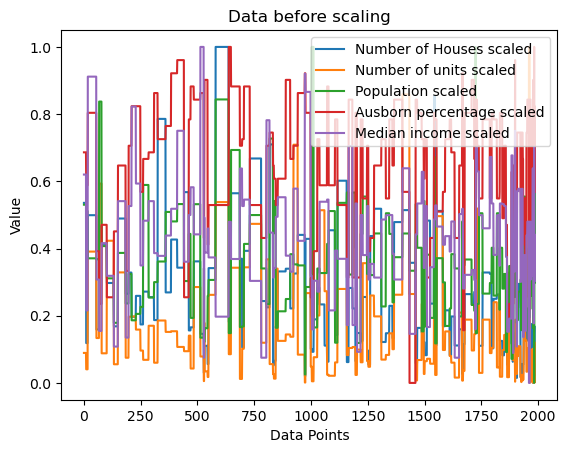

In [118]:
# after scaling 
minmax_df['nh_scaled'].plot(label='Number of Houses scaled')
minmax_df['nu_scaled'].plot(label='Number of units scaled')
minmax_df['pop_scaled'].plot(label='Population scaled')
minmax_df['ab_scaled'].plot(label='Ausborn percentage scaled')
minmax_df['mi_scaled'].plot(label='Median income scaled')
# minmax_df['mhp_scaled'].plot()
                     
                     
# x, y axes
plt.xlabel('Data Points')
plt.ylabel('Value')
plt.title('Data before scaling')

# Add legend
plt.legend()

In [119]:
minmax_df.describe().round(2)

number_of_houses  number_of_units  population  aus_born_perc  \
count           1987.00          1987.00     1987.00        1987.00   
mean            5879.54          3388.47    20404.32           0.69   
std             3476.17          2851.01     8964.63           0.10   
min              363.00            60.00      170.00           0.36   
25%             3150.00          1307.50    13849.00           0.63   
50%             5052.00          2524.00    19624.00           0.70   
75%             8074.00          4557.00    26045.00           0.77   
max            16913.00         16139.00    54005.00           0.87   

       median_income  median_house_price  nh_scaled  nu_scaled  pop_scaled  \
count        1987.00             1987.00    1987.00    1987.00     1987.00   
mean         1373.25          1221807.95       0.33       0.21        0.38   
std           317.85           482771.85       0.21       0.18        0.17   
min           633.00           507200.00       0.00       0.00        0.00   
25%          1180.00           887200.00       0.17       0.08        0.25   
50%          1360.00          1124800.00       0.28       0.15        0.36   
75%          1551.00          1438700.00       0.47       0.28        0.48   
max          2352.00          2733900.00       1.00       1.00        1.00   

       ab_scaled  mi_scaled  mhp_scaled  
count    1987.00    1987.00     1987.00  
mean        0.64       0.43        0.32  
std         0.20       0.18        0.22  
min         0.00       0.00        0.00  
25%         0.53       0.32        0.17  
50%         0.67       0.42        0.28  
75%         0.80       0.53        0.42  
max         1.00       1.00        1.00

### Data transformation

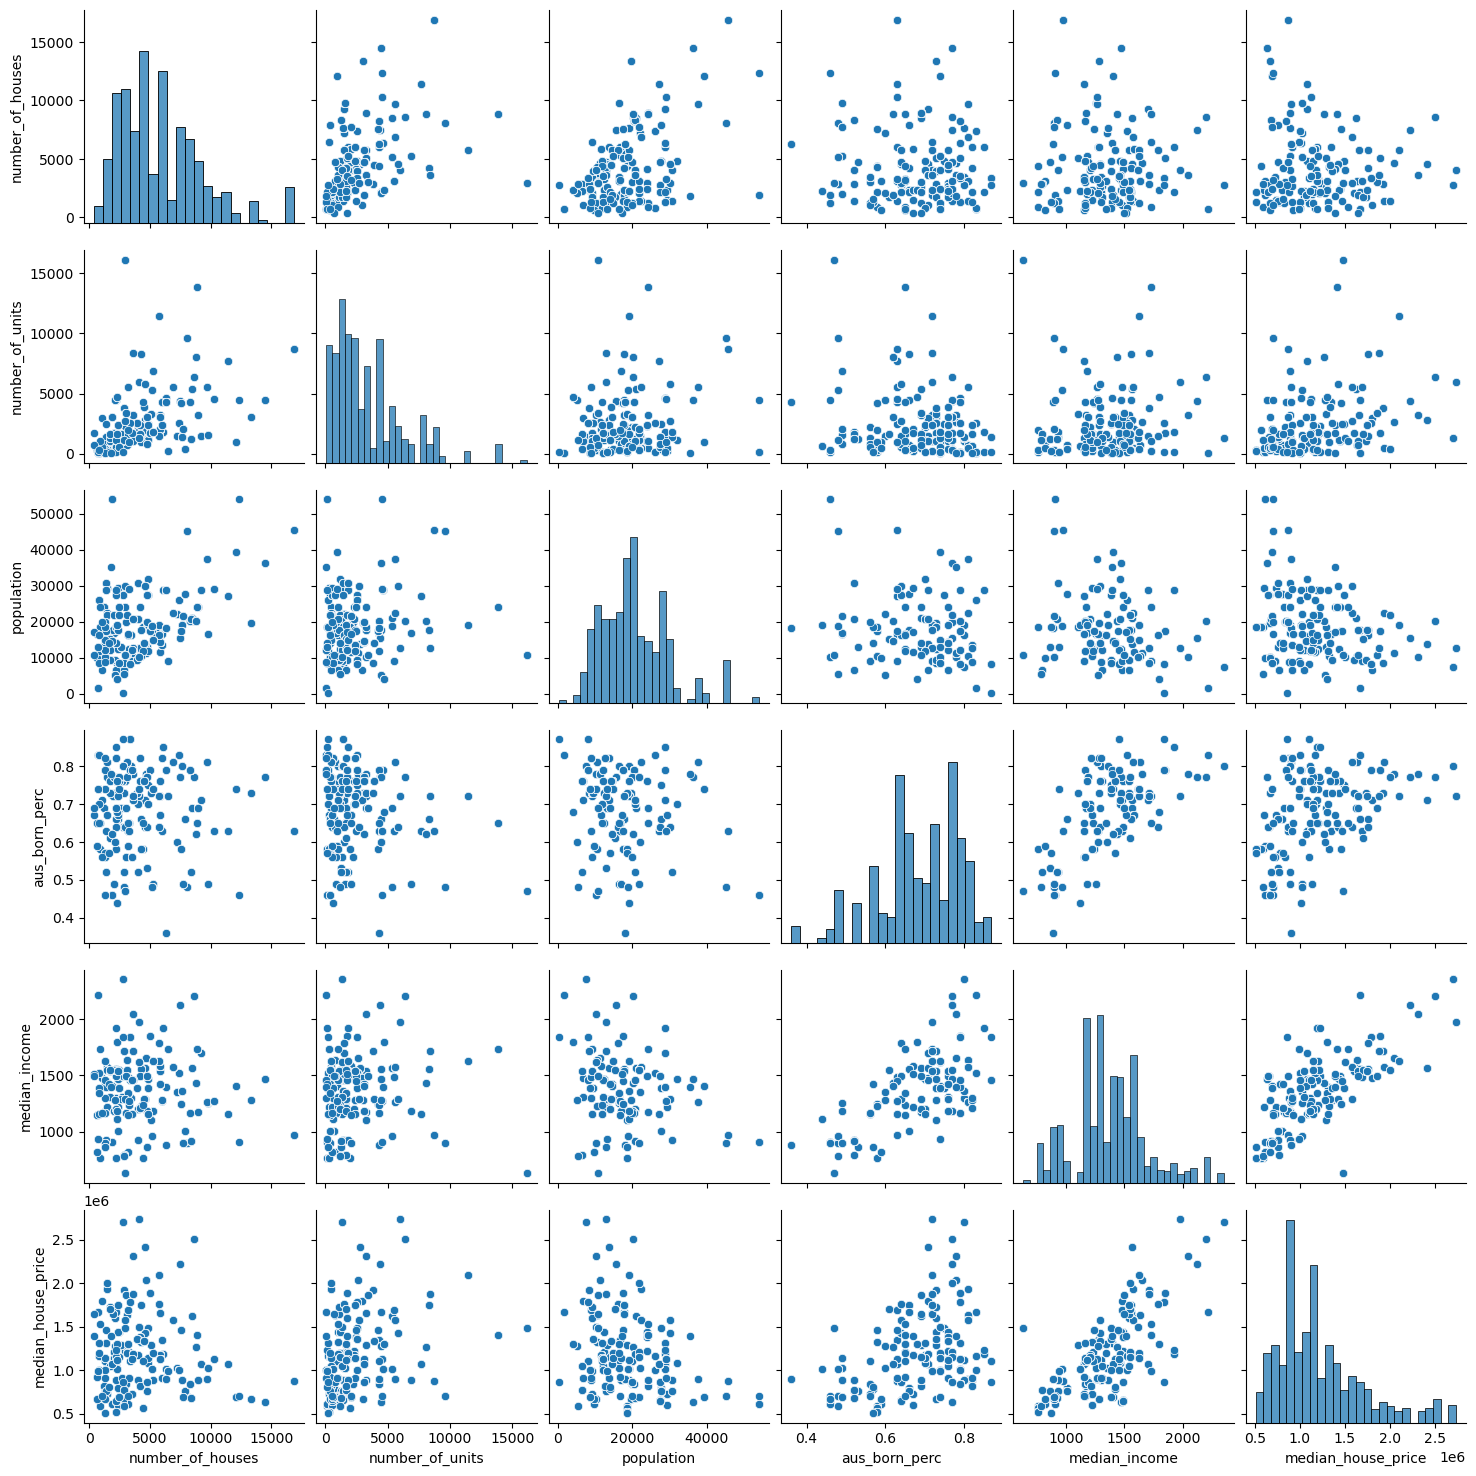

In [120]:
sns.pairplot(df[list(df.columns)])

In [124]:
features = ['nh_scaled', 'nu_scaled', 'pop_scaled', 'ab_scaled', 'mi_scaled', 'mhp_scaled', 'median_house_price']

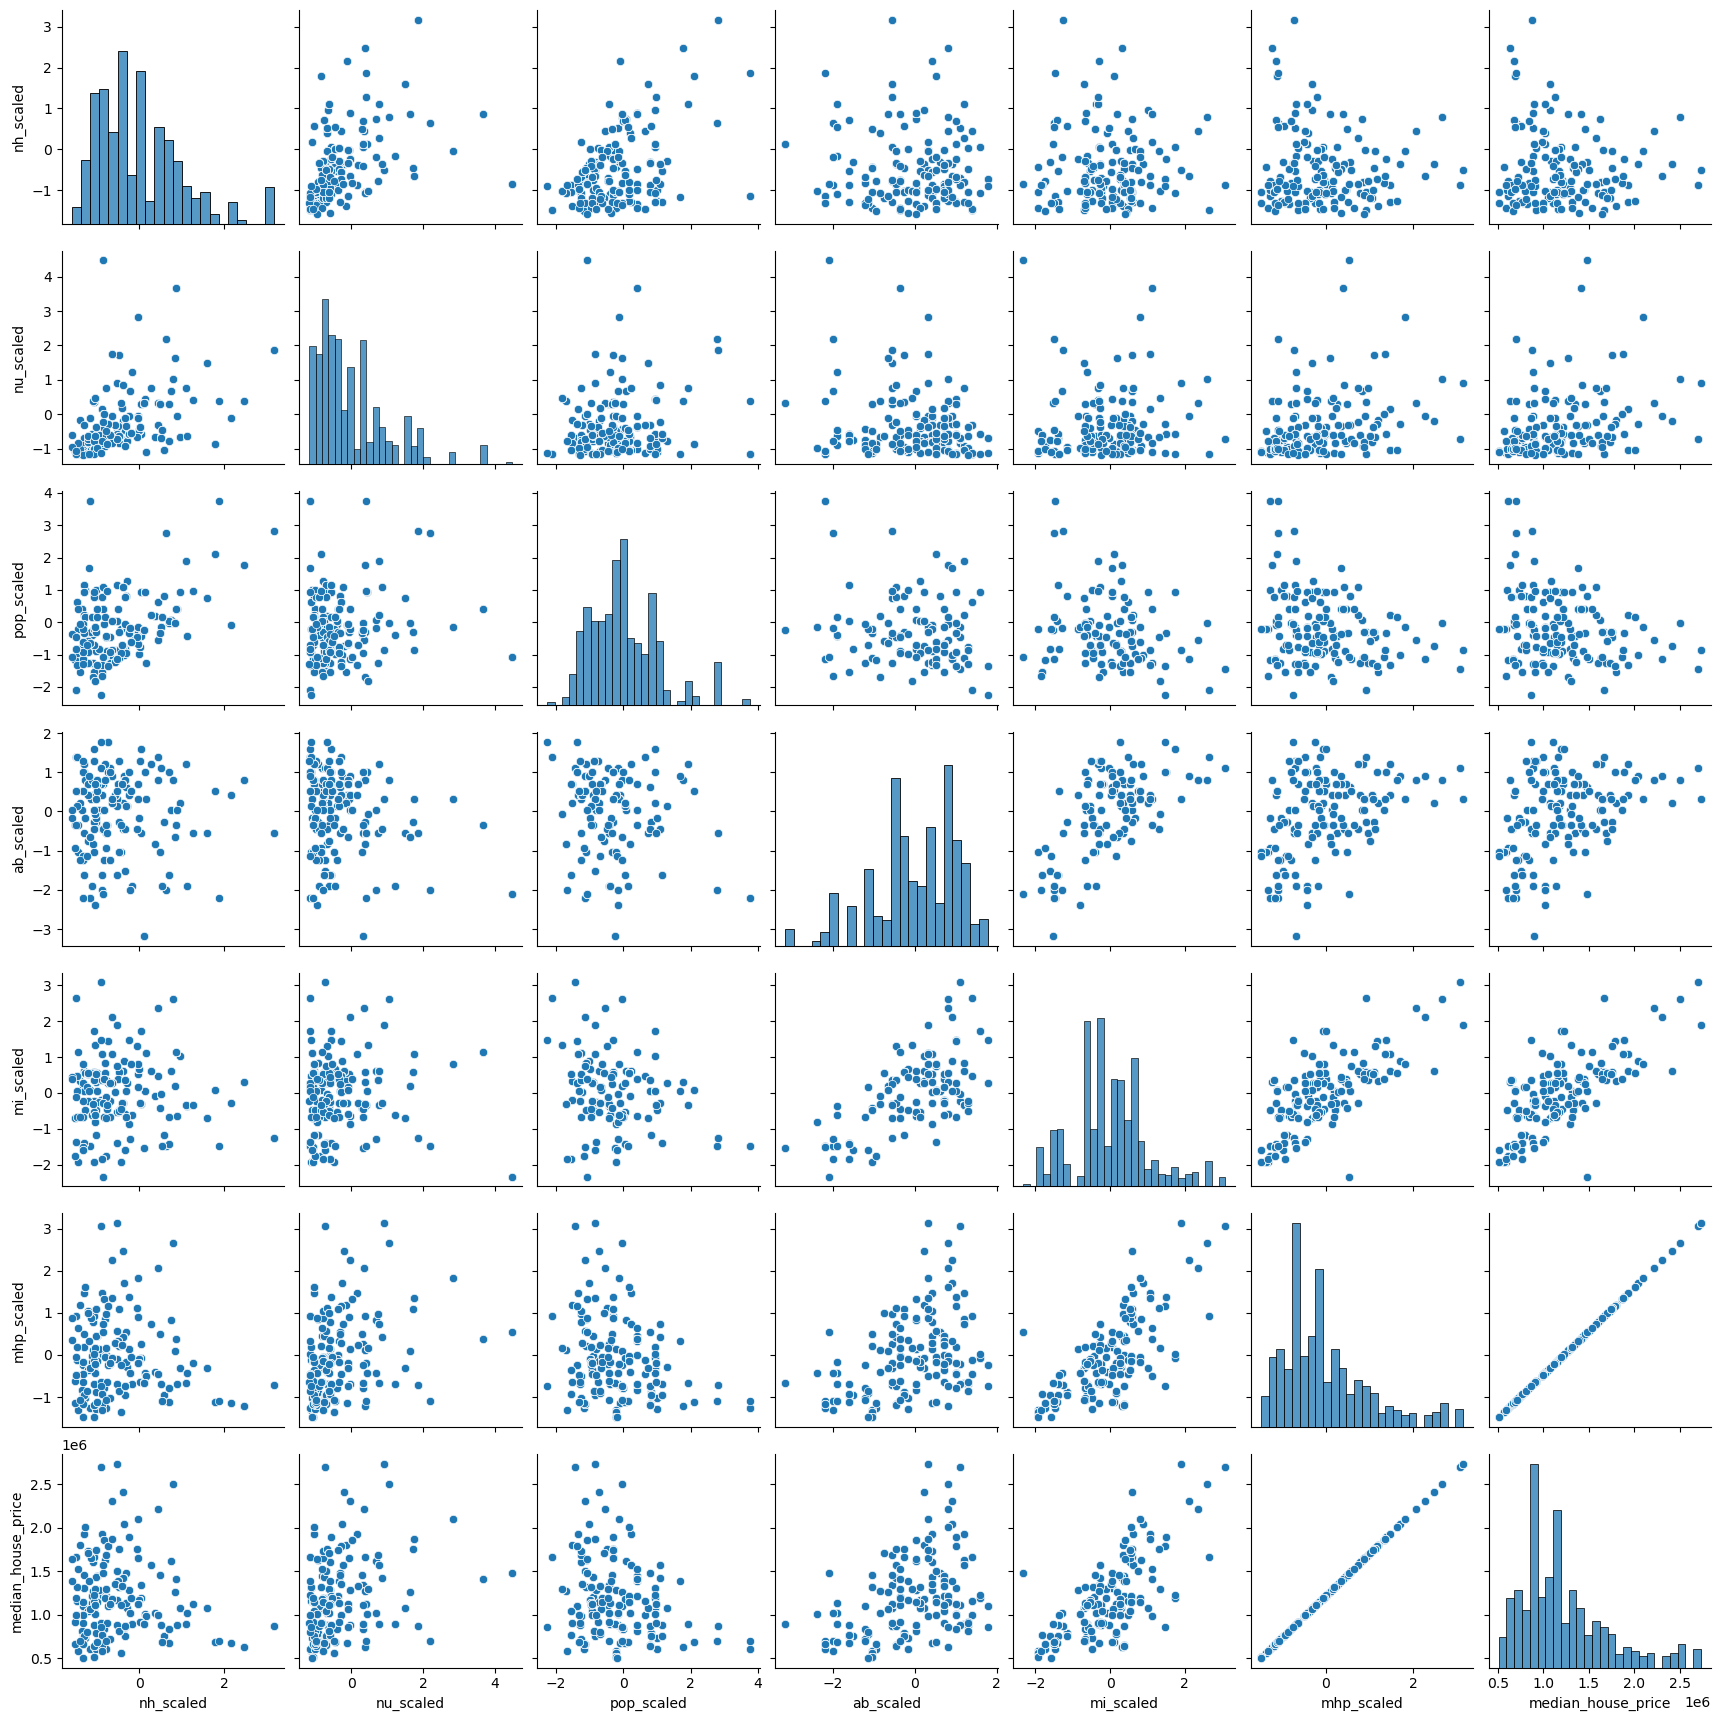

In [125]:
sns.pairplot(z_nor_df[features])

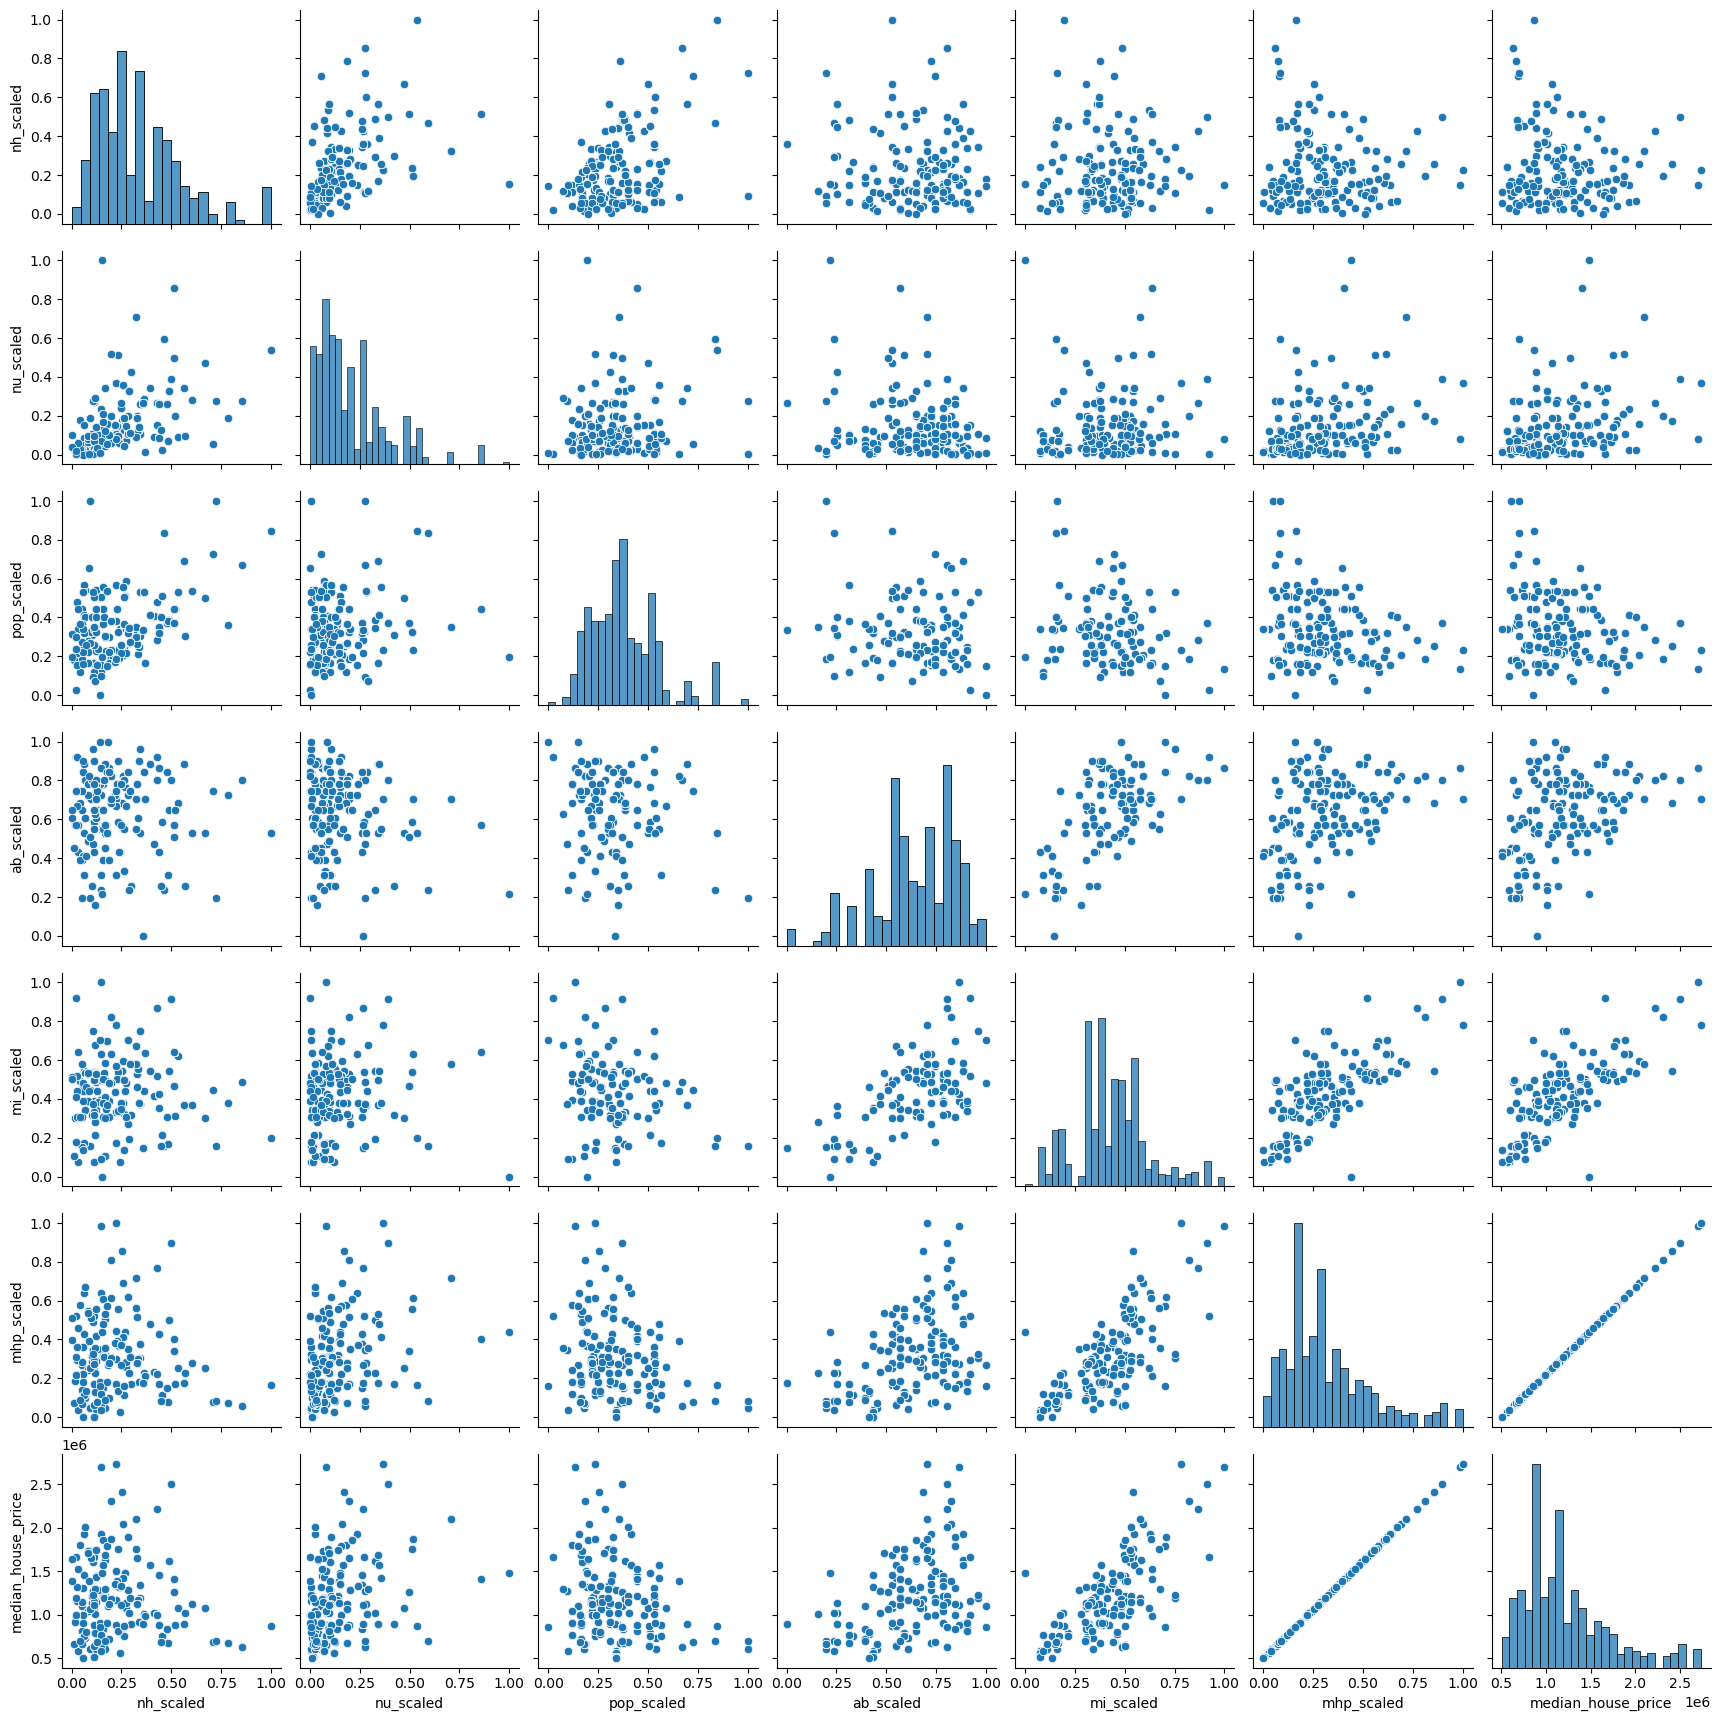

In [126]:
sns.pairplot(minmax_df[features])

#### log transformation

In [202]:
# original data
df['number_of_houses_l'] = np.log(df['number_of_houses'])
df['number_of_units_l'] = np.log(df['number_of_units'])
df['population_l'] = np.log(df['population'])
df['aus_born_perc_l'] = np.log(df['aus_born_perc'])
df['median_income_l'] = np.log(df['median_income'])
df['median_house_price_l'] = np.log(df['median_house_price'])

C:\Users\non_n\AppData\Local\Temp\ipykernel_30196\3457944626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_of_houses_l'] = np.log(df['number_of_houses'])
C:\Users\non_n\AppData\Local\Temp\ipykernel_30196\3457944626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_of_units_l'] = np.log(df['number_of_units'])
C:\Users\non_n\AppData\Local\Temp\ipykernel_30196\3457944626.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [209]:
ori_features = ['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income', 'median_house_price']

In [220]:
ori_features_log = [f'{f}_l' for f in ori_features]

In [207]:
# z normalised data
z_nor_df['nh_scaled_l'] = np.log1p(z_nor_df['nh_scaled'])
z_nor_df['nu_scaled_l'] = np.log1p(z_nor_df['nu_scaled'])
z_nor_df['pop_scaled_l'] = np.log1p(z_nor_df['pop_scaled'])
z_nor_df['ab_scaled_l'] = np.log1p(z_nor_df['ab_scaled'])
z_nor_df['mi_scaled_l'] = np.log1p(z_nor_df['mi_scaled'])
z_nor_df['mhp_scaled_l'] = np.log1p(z_nor_df['mhp_scaled'])

C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = geta

In [206]:
scaled_features_log = ['nh_scaled_l', 'nu_scaled_l', 'pop_scaled_l', 'ab_scaled_l', 'mi_scaled_l', 'mhp_scaled_l', 'median_house_price']

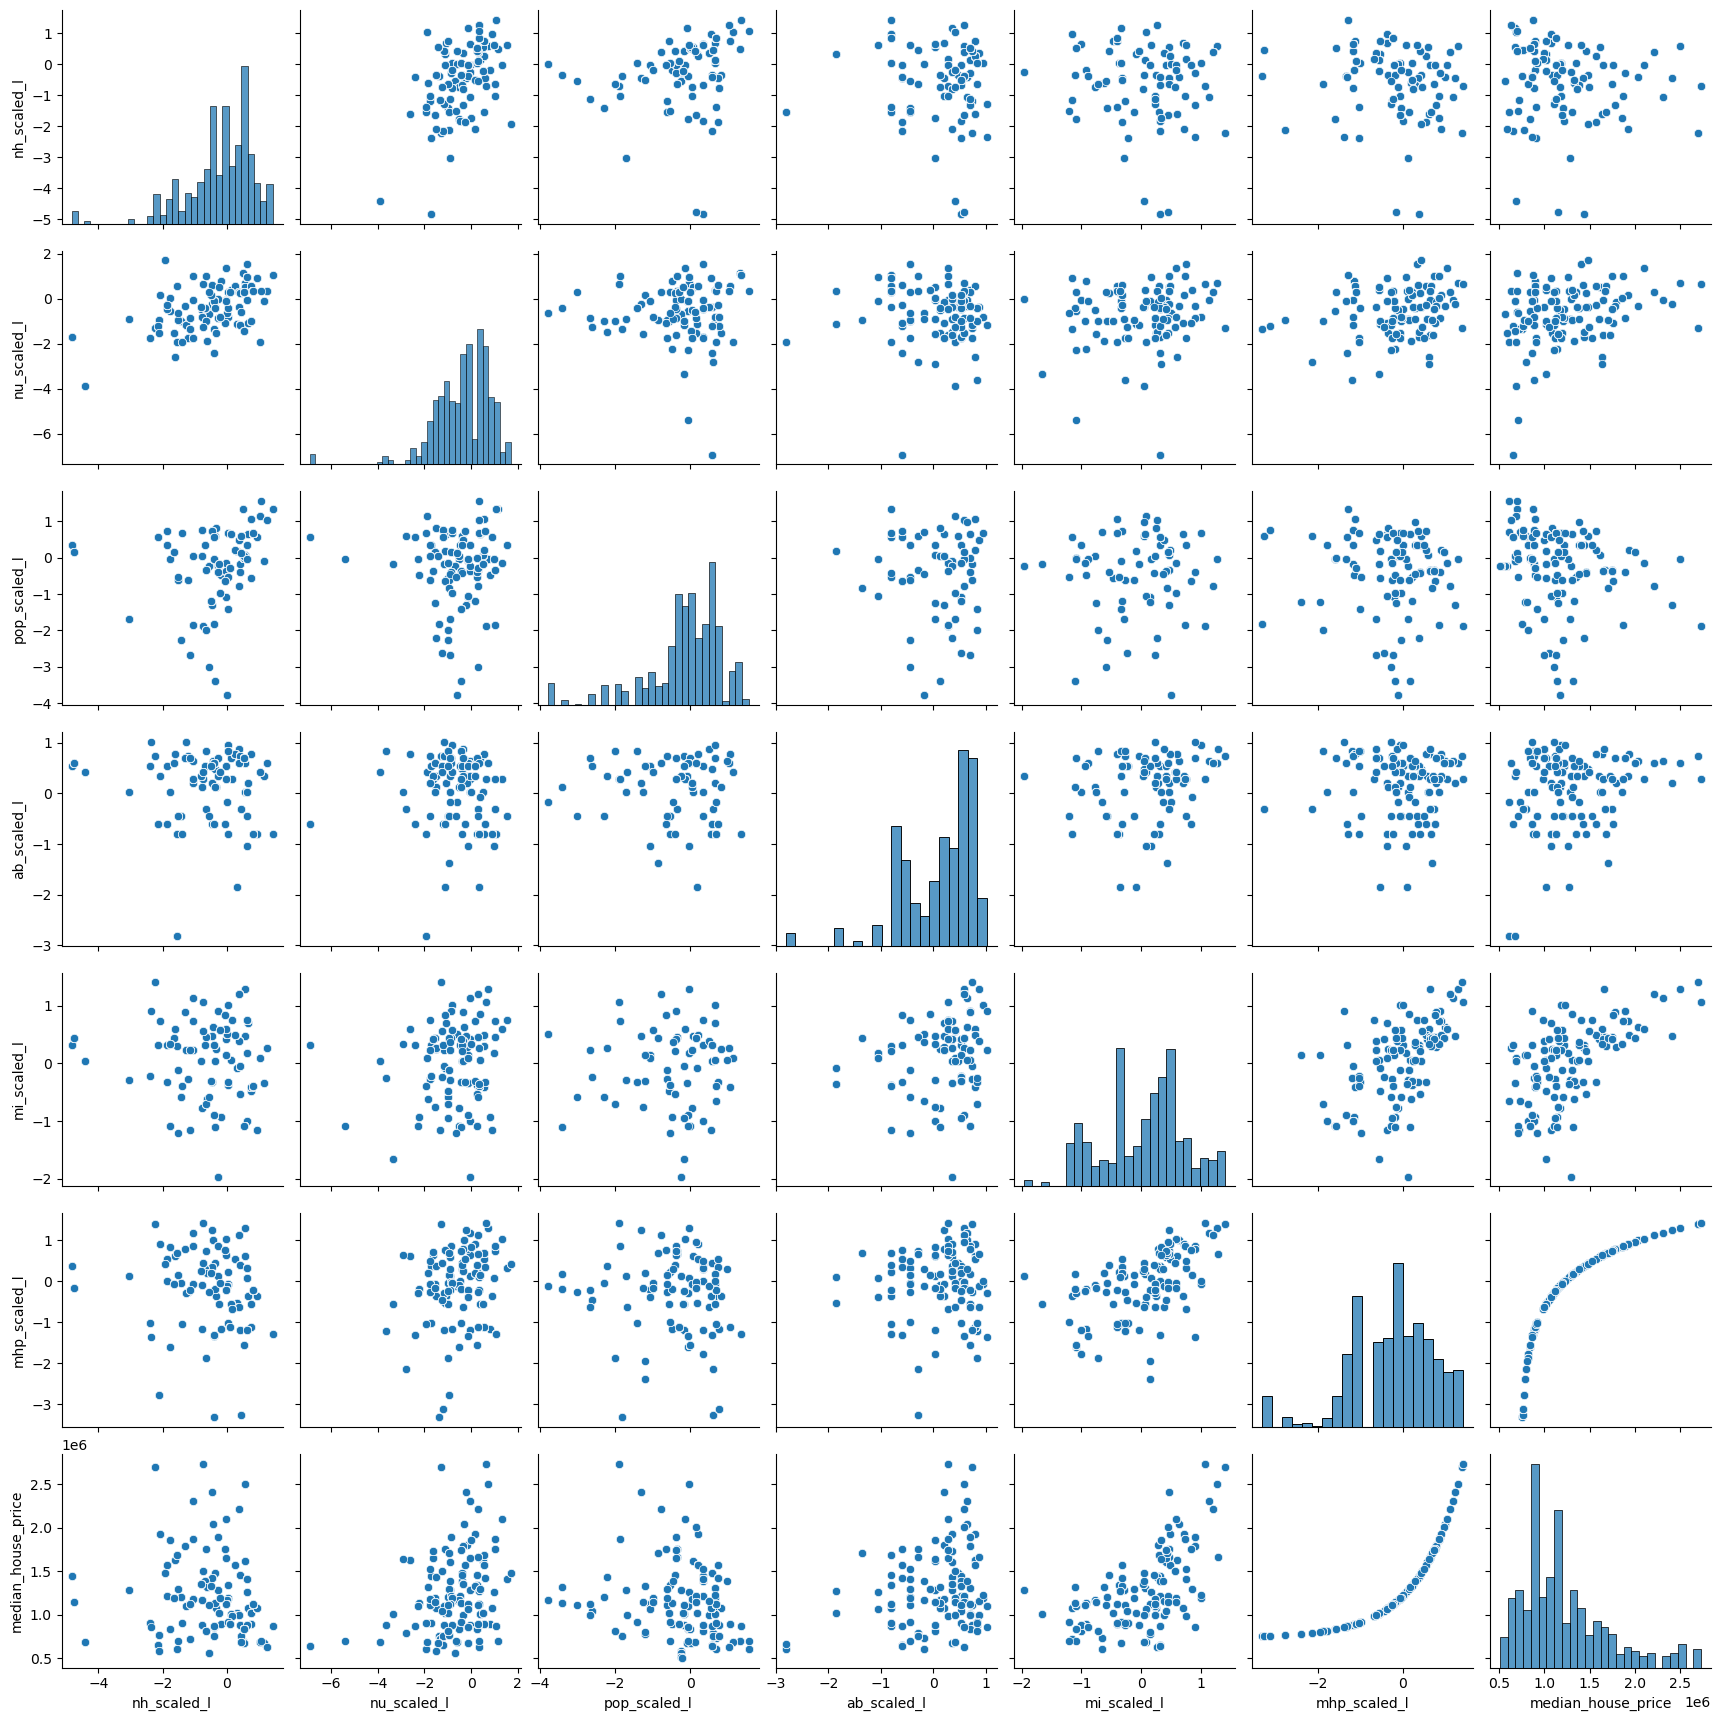

In [278]:
sns.pairplot(z_nor_df[scaled_features_log])

In [216]:
# min-max scaled data
minmax_df['nh_scaled_l'] = np.log(minmax_df['nh_scaled'])
minmax_df['nu_scaled_l'] = np.log(minmax_df['nu_scaled'])
minmax_df['pop_scaled_l'] = np.log(minmax_df['pop_scaled'])
minmax_df['ab_scaled_l'] = np.log(minmax_df['ab_scaled'])
minmax_df['mi_scaled_l'] = np.log(minmax_df['mi_scaled'])
minmax_df['mhp_scaled_l'] = np.log(minmax_df['mhp_scaled'])

C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\non_n\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(uf

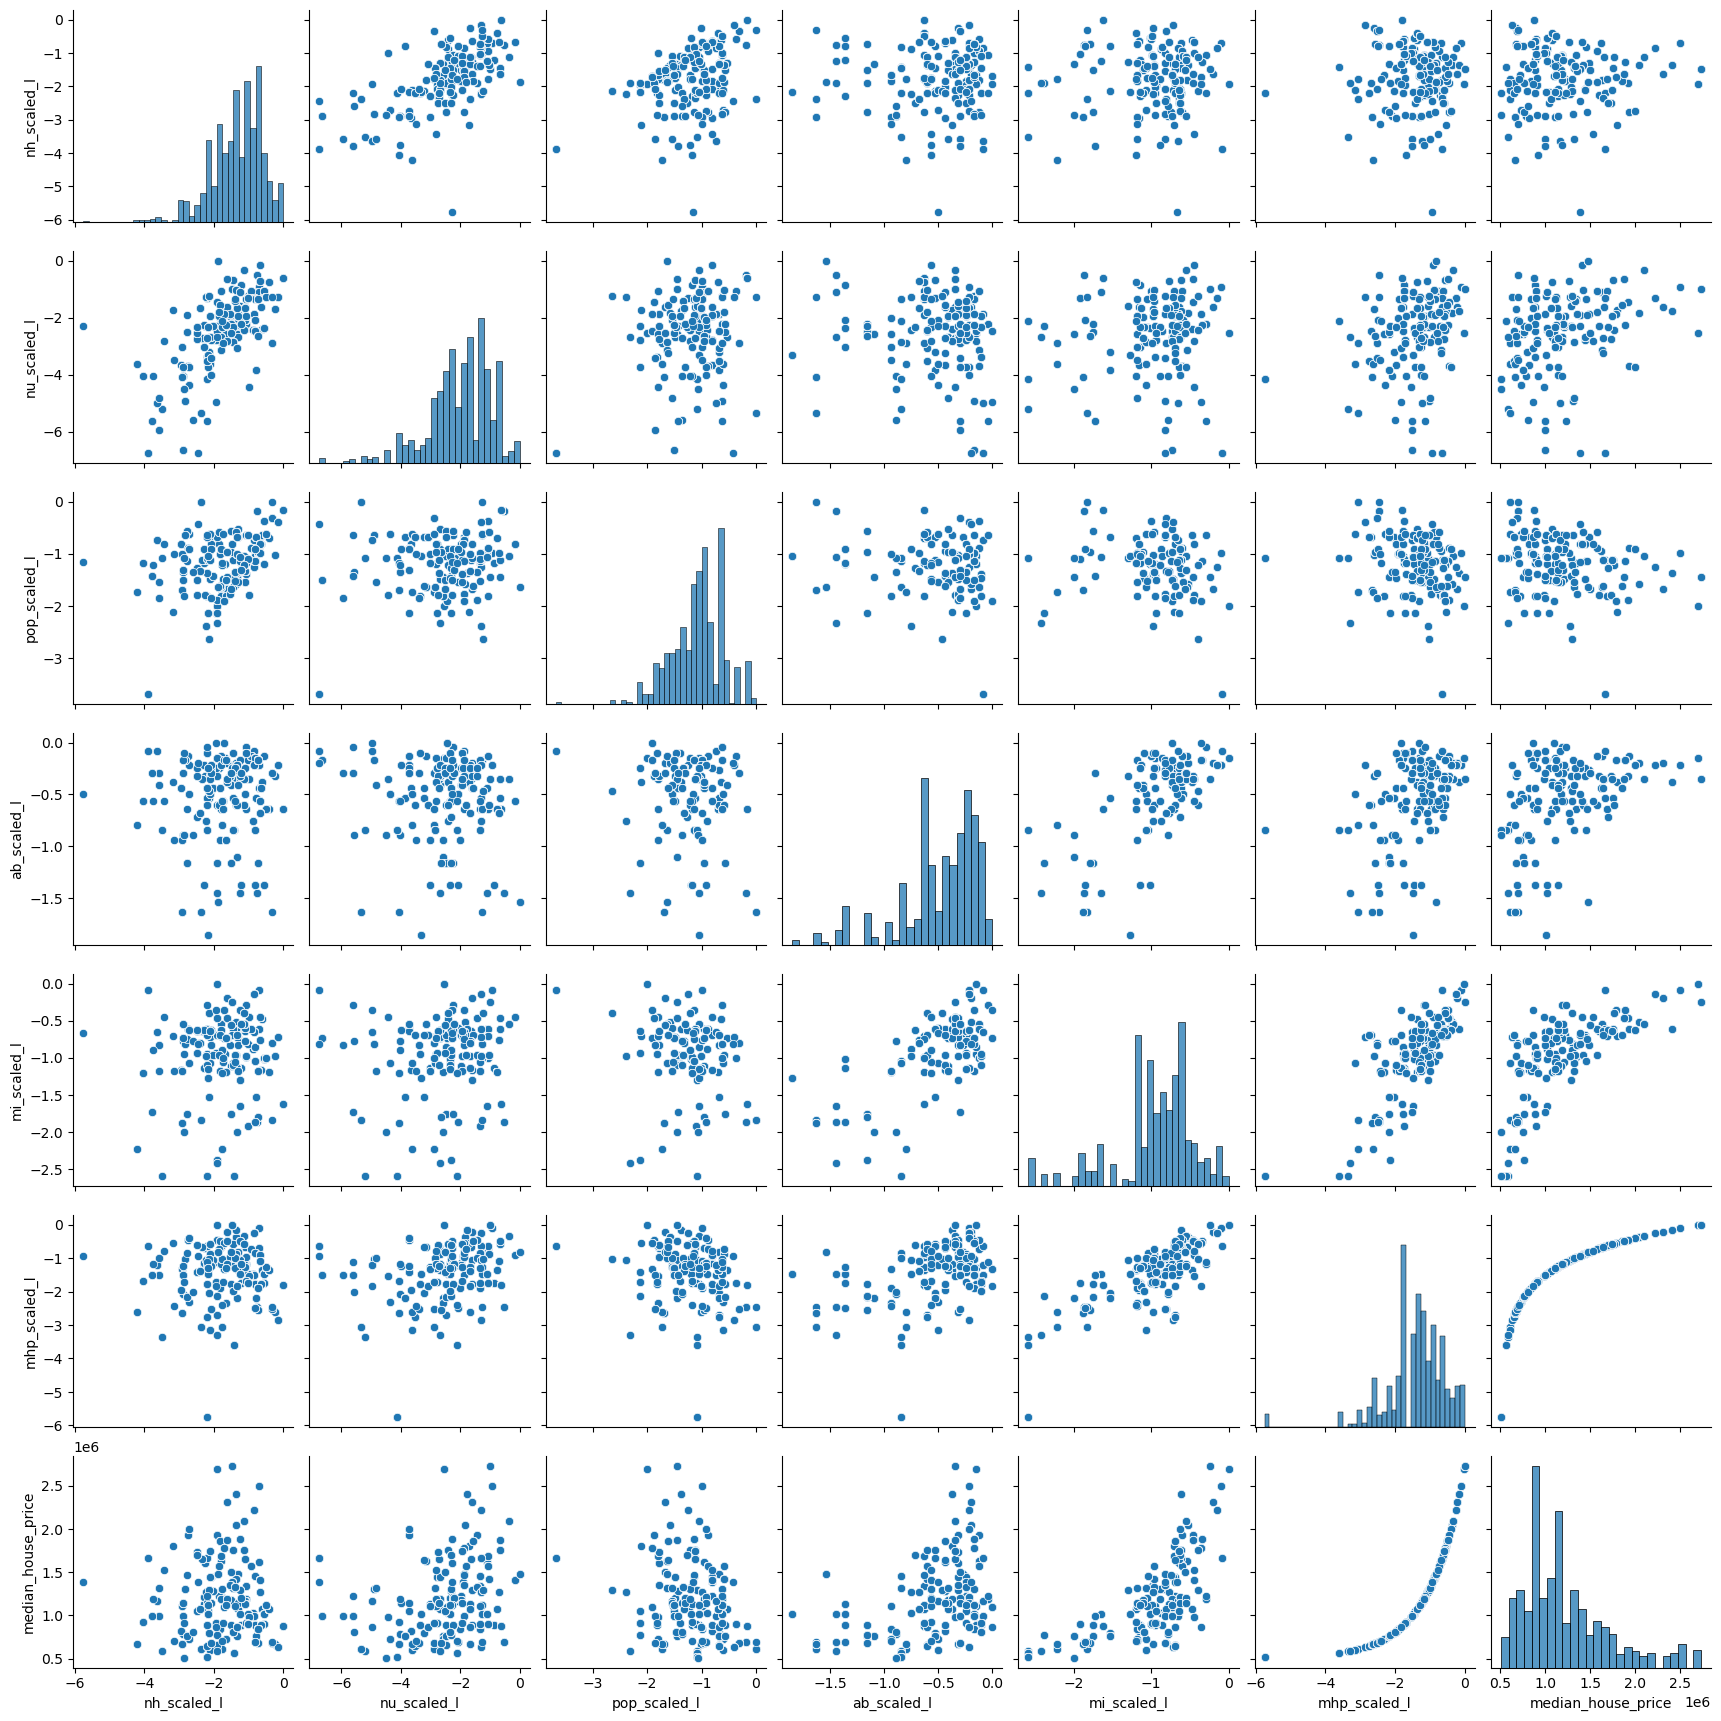

In [279]:
sns.pairplot(minmax_df[scaled_features_log])

<AxesSubplot:>

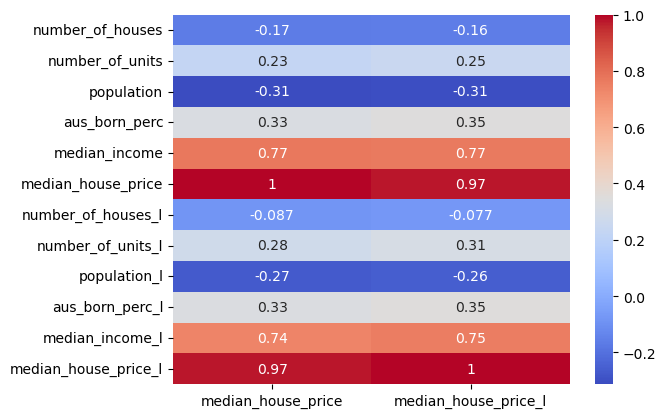

In [228]:
sns.heatmap(df.corr()[['median_house_price', 'median_house_price_l']], annot=True, cmap='coolwarm')

<AxesSubplot:>

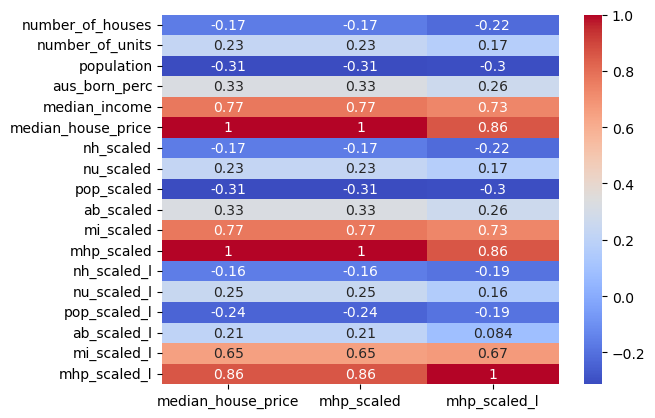

In [281]:
sns.heatmap(z_nor_df.corr()[['median_house_price', 'mhp_scaled', 'mhp_scaled_l']], annot=True, cmap='coolwarm')

#### power transformation

In [230]:
# original data
df['number_of_houses_p'] = df['number_of_houses'].pow(2)
df['number_of_units_p'] = df['number_of_units'].pow(2)
df['population_p'] = df['population'].pow(2)
df['aus_born_perc_p'] = df['aus_born_perc'].pow(2)
df['median_income_p'] = df['median_income'].pow(2)
df['median_house_price_p'] = df['median_house_price'].pow(2)

C:\Users\non_n\AppData\Local\Temp\ipykernel_30196\3639331712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_of_houses_p'] = df['number_of_houses'].pow(2)
C:\Users\non_n\AppData\Local\Temp\ipykernel_30196\3639331712.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_of_units_p'] = df['number_of_units'].pow(2)
C:\Users\non_n\AppData\Local\Temp\ipykernel_30196\3639331712.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [231]:
ori_features_pow = ['number_of_houses_p', 'number_of_units_p', 'population_p', 'aus_born_perc_p', 'median_income_p', 'median_house_price_p', 'median_house_price']

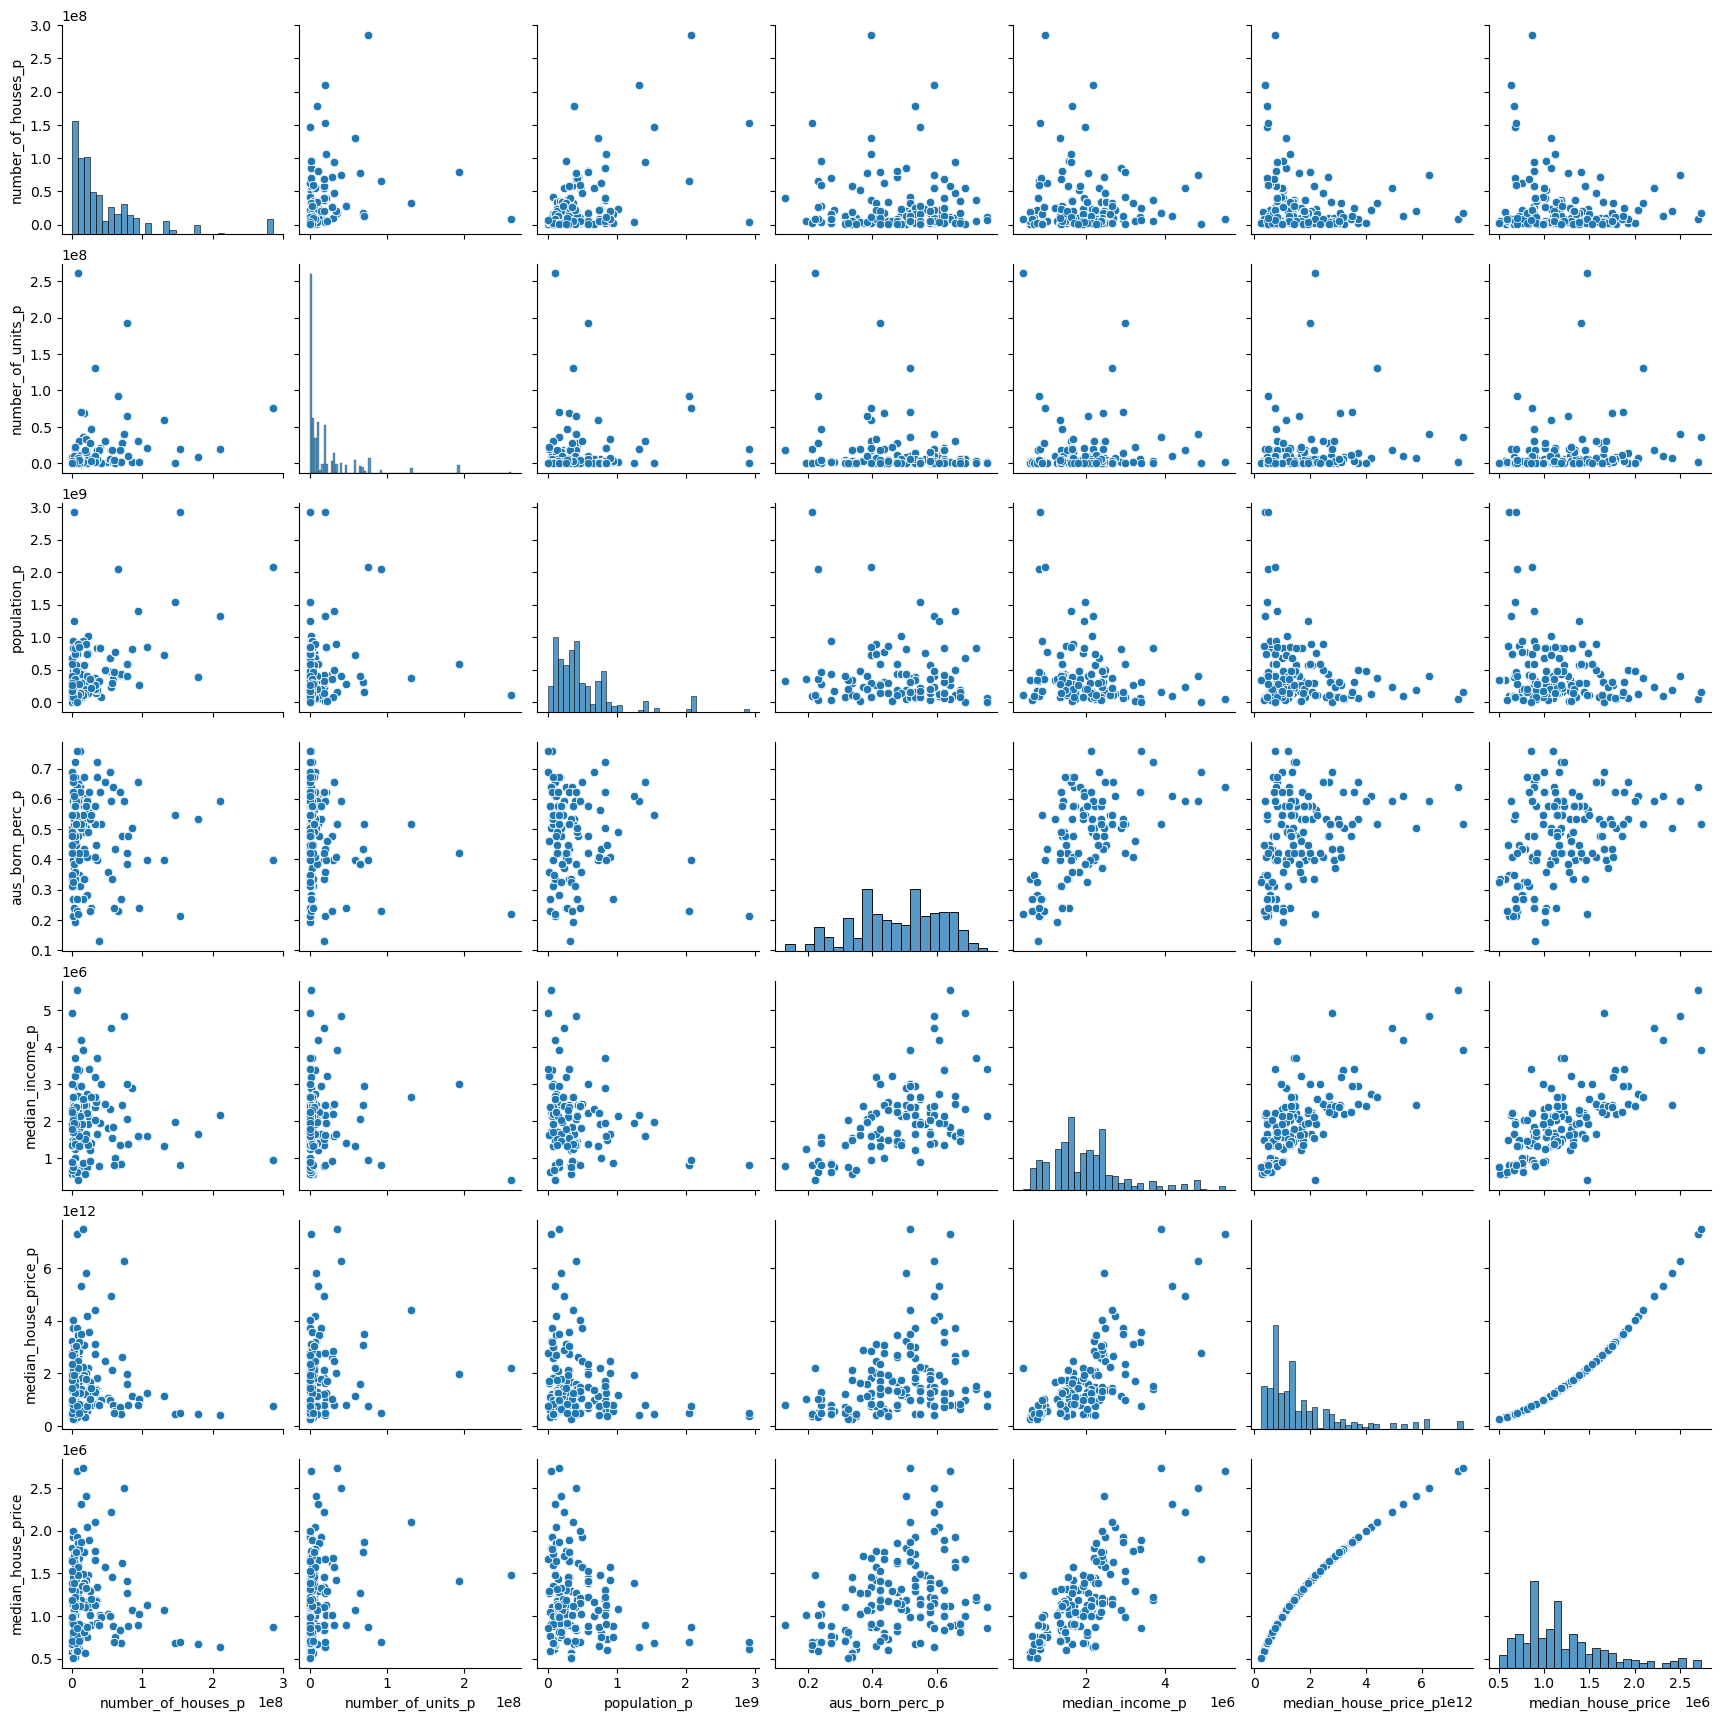

In [238]:
sns.pairplot(df[ori_features_pow])

In [140]:
# z normalised data
z_nor_df['nh_scaled_p'] = z_nor_df['nh_scaled'].pow(2)
z_nor_df['nu_scaled_p'] = z_nor_df['nu_scaled'].pow(2)
z_nor_df['pop_scaled_p'] = z_nor_df['pop_scaled'].pow(2)
z_nor_df['ab_scaled_p'] = z_nor_df['ab_scaled'].pow(2)
z_nor_df['mi_scaled_p'] = z_nor_df['mi_scaled'].pow(2)
z_nor_df['mhp_scaled_p'] = z_nor_df['mhp_scaled'].pow(2)

In [141]:
plot_features = ['nh_scaled_p', 'nu_scaled_p', 'pop_scaled_p', 'ab_scaled_p', 'mi_scaled_p', 'mhp_scaled_p' ,'median_house_price']

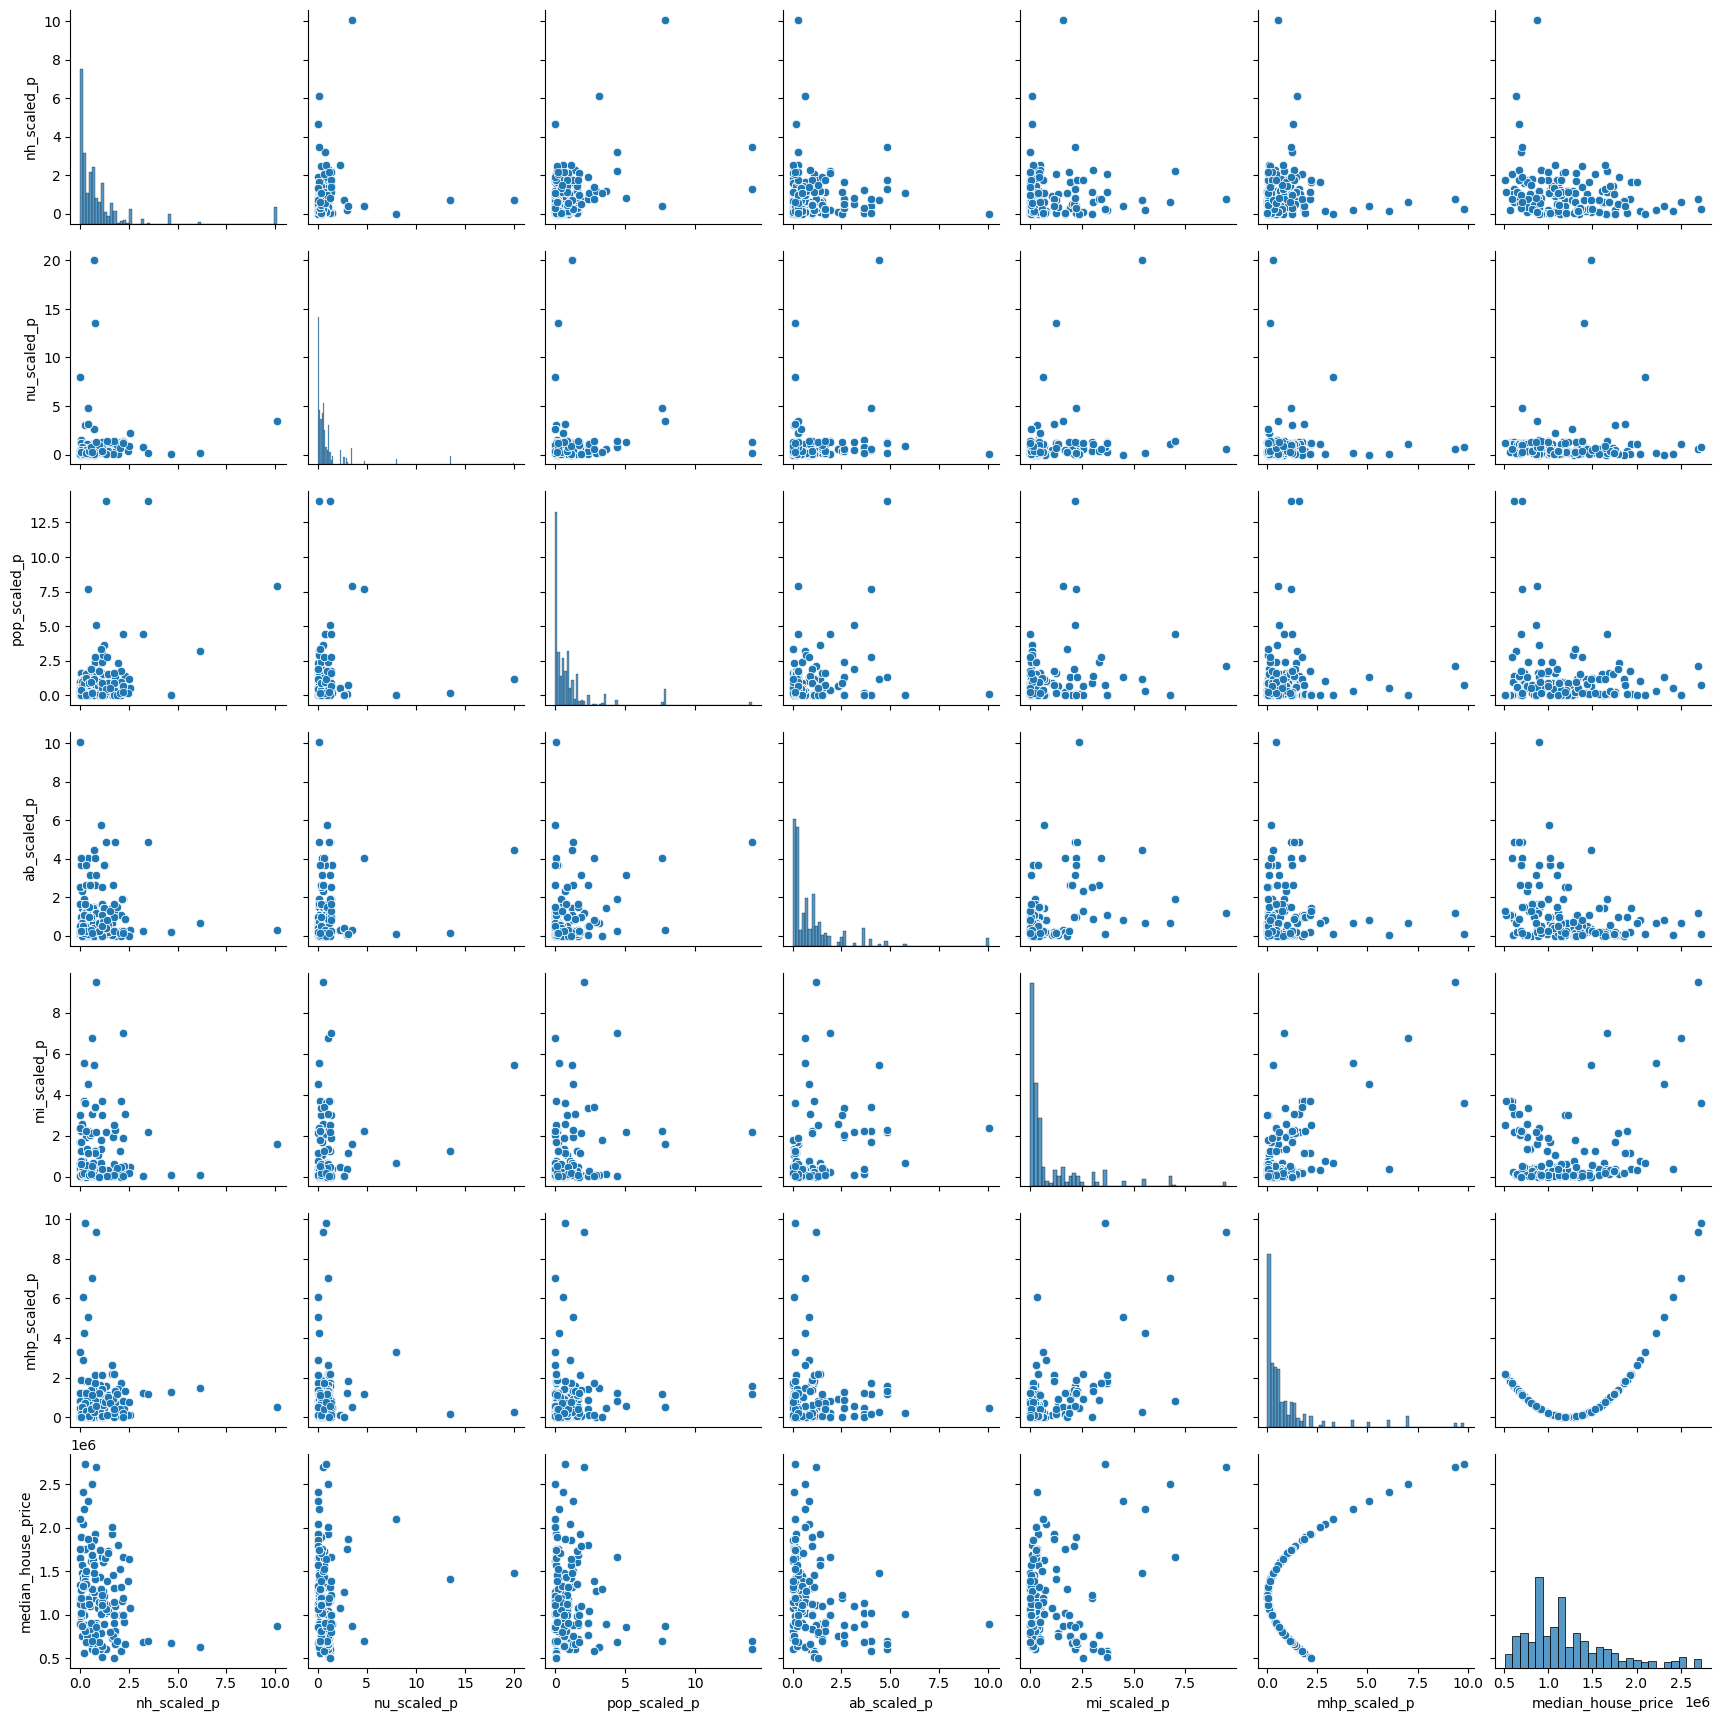

In [142]:
sns.pairplot(z_nor_df[plot_features])

In [143]:
# min-max scaled data
minmax_df['nh_scaled_p'] = minmax_df['nh_scaled'].pow(2)
minmax_df['nu_scaled_p'] = minmax_df['nu_scaled'].pow(2)
minmax_df['pop_scaled_p'] = minmax_df['pop_scaled'].pow(2)
minmax_df['ab_scaled_p'] = minmax_df['ab_scaled'].pow(2)
minmax_df['mi_scaled_p'] = minmax_df['mi_scaled'].pow(2)
minmax_df['mhp_scaled_p'] = minmax_df['mhp_scaled'].pow(2)

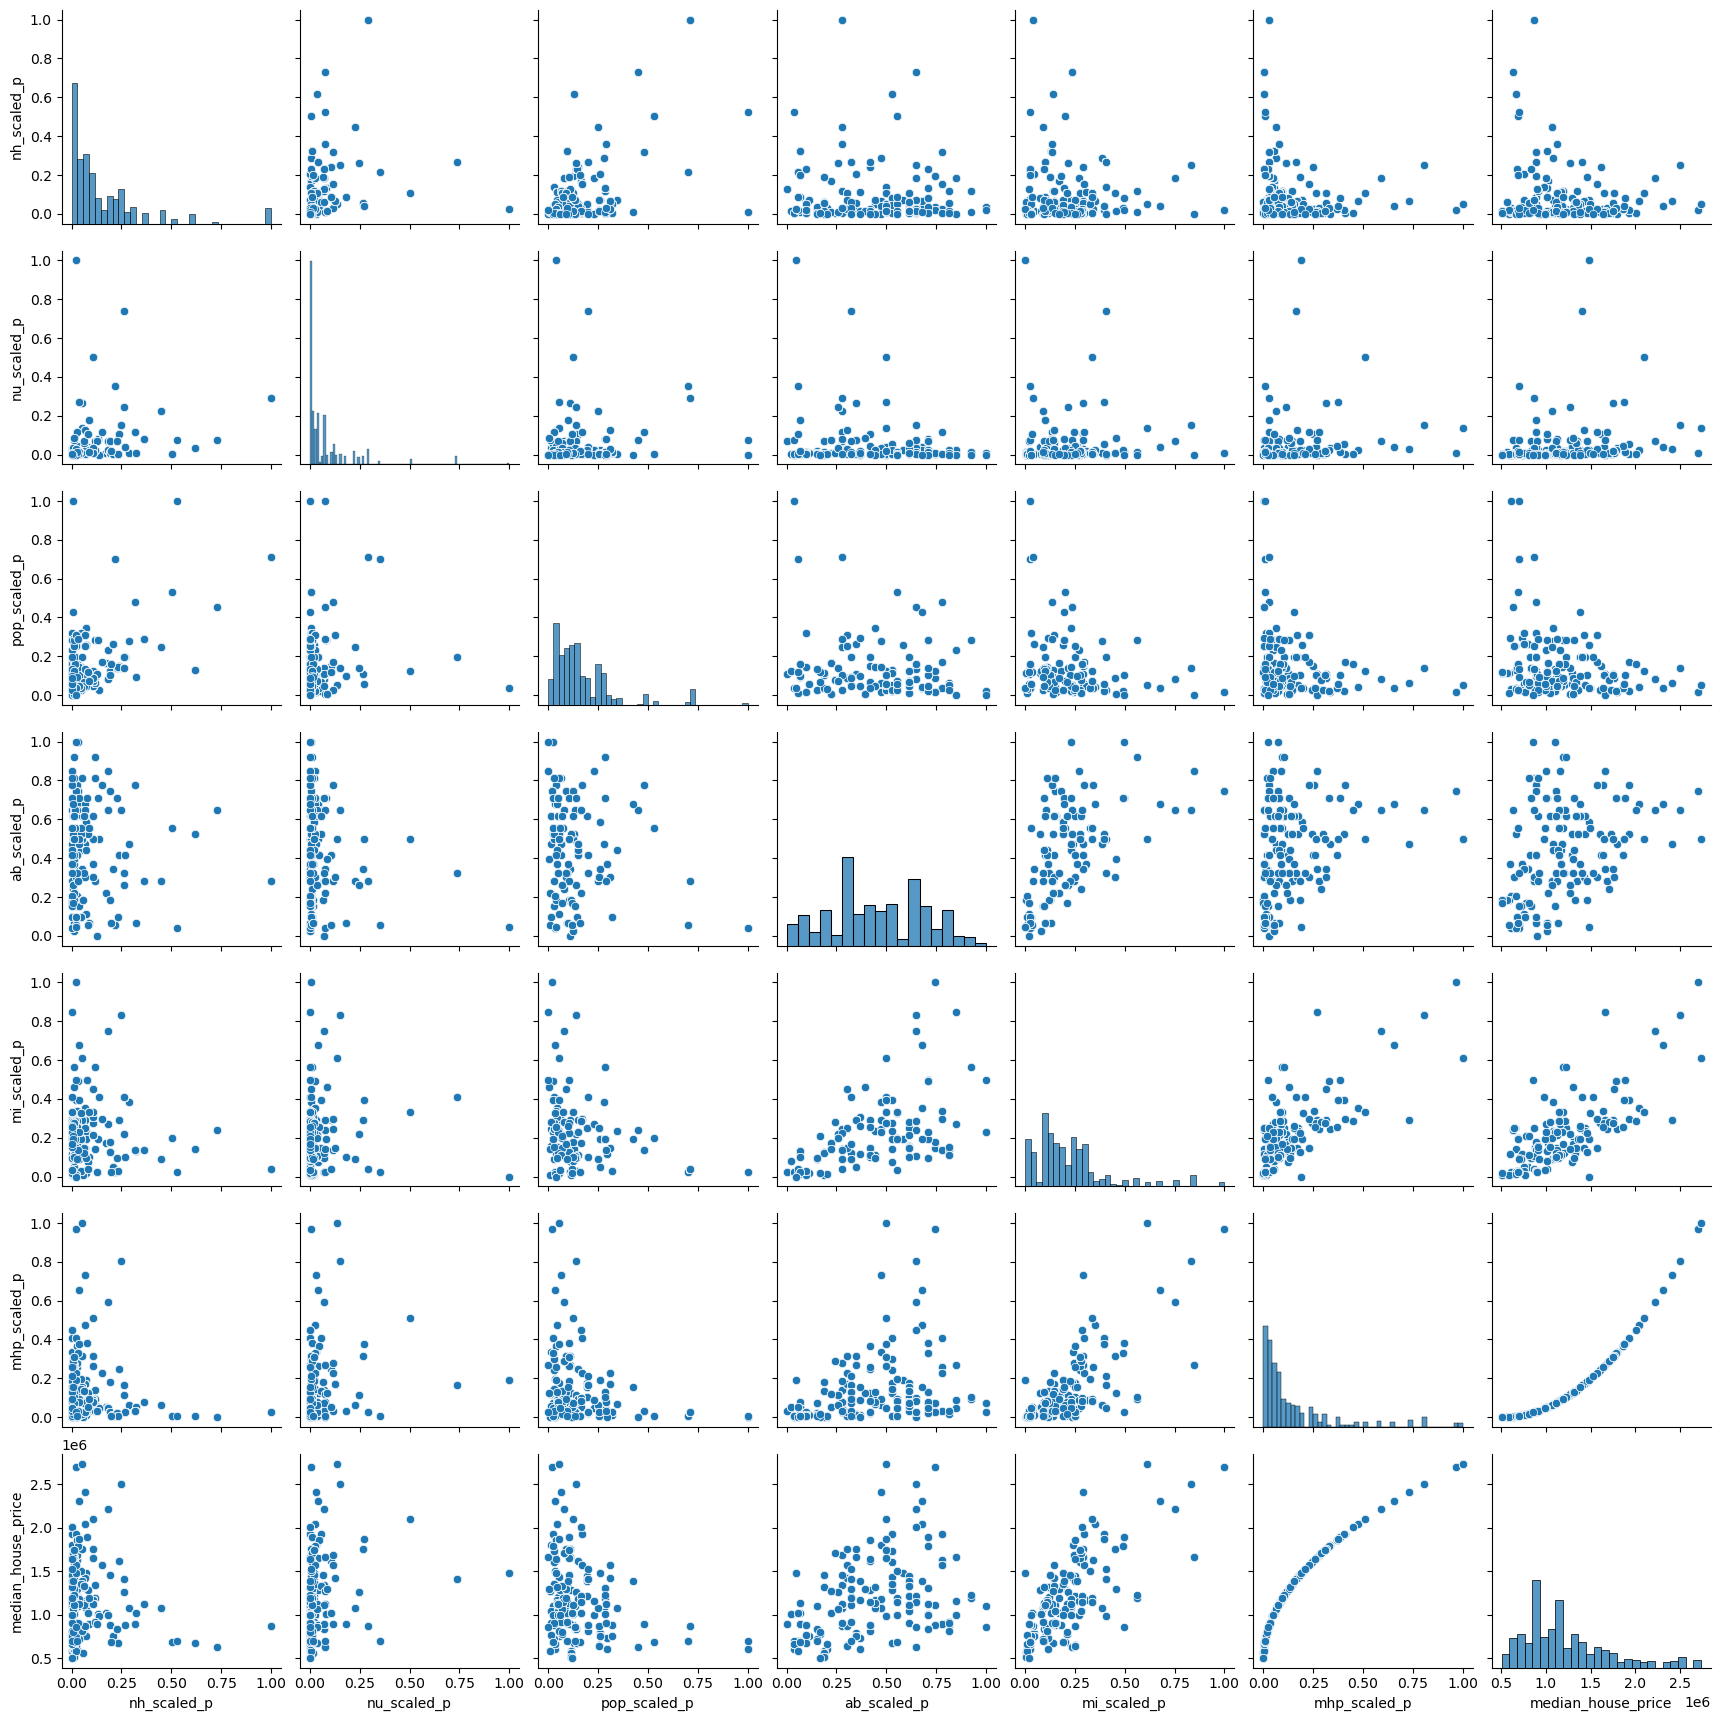

In [144]:
sns.pairplot(minmax_df[plot_features])

In [145]:
minmax_df.describe()

number_of_houses  number_of_units    population  aus_born_perc  \
count       1987.000000      1987.000000   1987.000000    1987.000000   
mean        5879.535984      3388.467539  20404.316558       0.686814   
std         3476.167919      2851.009813   8964.633718       0.103009   
min          363.000000        60.000000    170.000000       0.360000   
25%         3150.000000      1307.500000  13849.000000       0.630000   
50%         5052.000000      2524.000000  19624.000000       0.700000   
75%         8074.000000      4557.000000  26045.000000       0.770000   
max        16913.000000     16139.000000  54005.000000       0.870000   

       median_income  median_house_price    nh_scaled    nu_scaled  \
count    1987.000000        1.987000e+03  1987.000000  1987.000000   
mean     1373.248616        1.221808e+06     0.333325     0.207007   
std       317.850170        4.827719e+05     0.210040     0.177313   
min       633.000000        5.072000e+05     0.000000     0.000000   
25%      1180.000000        8.872000e+05     0.168399     0.077586   
50%      1360.000000        1.124800e+06     0.283323     0.153243   
75%      1551.000000        1.438700e+06     0.465921     0.279682   
max      2352.000000        2.733900e+06     1.000000     1.000000   

        pop_scaled    ab_scaled  ...  pop_scaled_l  ab_scaled_l  mi_scaled_l  \
count  1987.000000  1987.000000  ...   1987.000000  1987.000000  1987.000000   
mean      0.375858     0.640812  ...          -inf         -inf         -inf   
std       0.166521     0.201978  ...           NaN          NaN          NaN   
min       0.000000     0.000000  ...          -inf         -inf         -inf   
25%       0.254091     0.529412  ...     -1.370062    -0.635989    -1.145051   
50%       0.361363     0.666667  ...     -1.017871    -0.405465    -0.860572   
75%       0.480635     0.803922  ...     -0.732647    -0.218254    -0.627301   
max       1.000000     1.000000  ...      0.000000     0.000000     0.000000   

       mhp_scaled_l  nh_scaled_p  nu_scaled_p  pop_scaled_p  ab_scaled_p  \
count  1.987000e+03  1987.000000  1987.000000   1987.000000  1987.000000   
mean           -inf     0.155201     0.074276      0.168984     0.451415   
std             NaN     0.198434     0.128802      0.157149     0.235209   
min            -inf     0.000000     0.000000      0.000000     0.000000   
25%   -1.768105e+00     0.028358     0.006021      0.064562     0.280277   
50%   -1.282435e+00     0.080272     0.023484      0.130584     0.444444   
75%   -8.714798e-01     0.217083     0.078222      0.231010     0.646290   
max   -1.110223e-16     1.000000     1.000000      1.000000     1.000000   

       mi_scaled_p  mhp_scaled_p  
count  1987.000000   1987.000000  
mean      0.219612      0.149977  
std       0.183303      0.201797  
min       0.000000      0.000000  
25%       0.101257      0.029124  
50%       0.178862      0.076929  
75%       0.285190      0.175002  
max       1.000000      1.000000  

[8 rows x 24 columns]

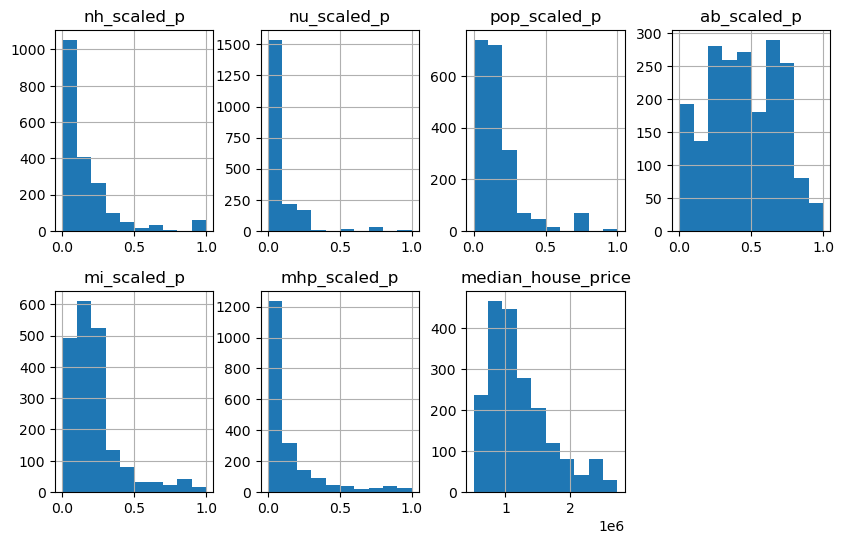

In [146]:
minmax_df[plot_features].hist(layout=(2, 4), figsize=(10, 6));

#### box-cox transformation

In [264]:
box_cox_t = preprocessing.PowerTransformer(method='box-cox', standardize=False)
cols_original = ['number_of_houses', 'number_of_units', 'population', 'aus_born_perc','median_income', 'median_house_price']

In [265]:
# original data
original_mat = box_cox_t.fit_transform(df[cols_original])

In [272]:
bc_cols = [f'{c}_bc' for c in cols_original]

In [274]:
bc_cols.append('median_house_price')

In [ ]:
df = pd.concat([df, pd.DataFrame(original_mat, columns=bc_cols)], axis=1)

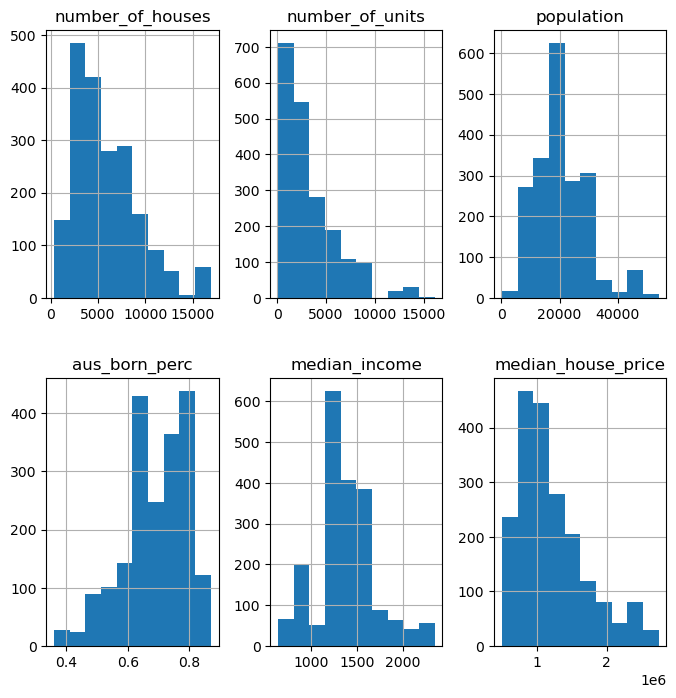

In [267]:
df[cols].hist(layout= (2, 3), figsize=(8, 8));

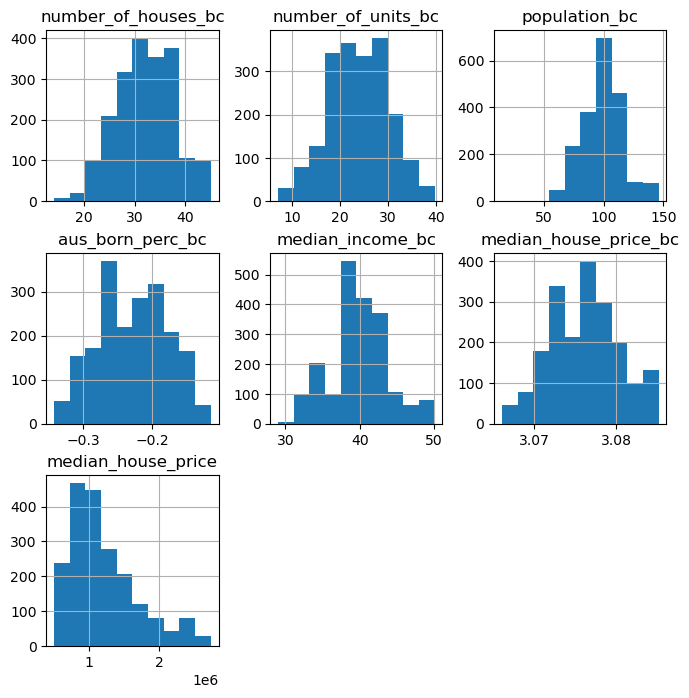

In [276]:
df[bc_cols].hist(layout= (3, 3), figsize=(8, 8));

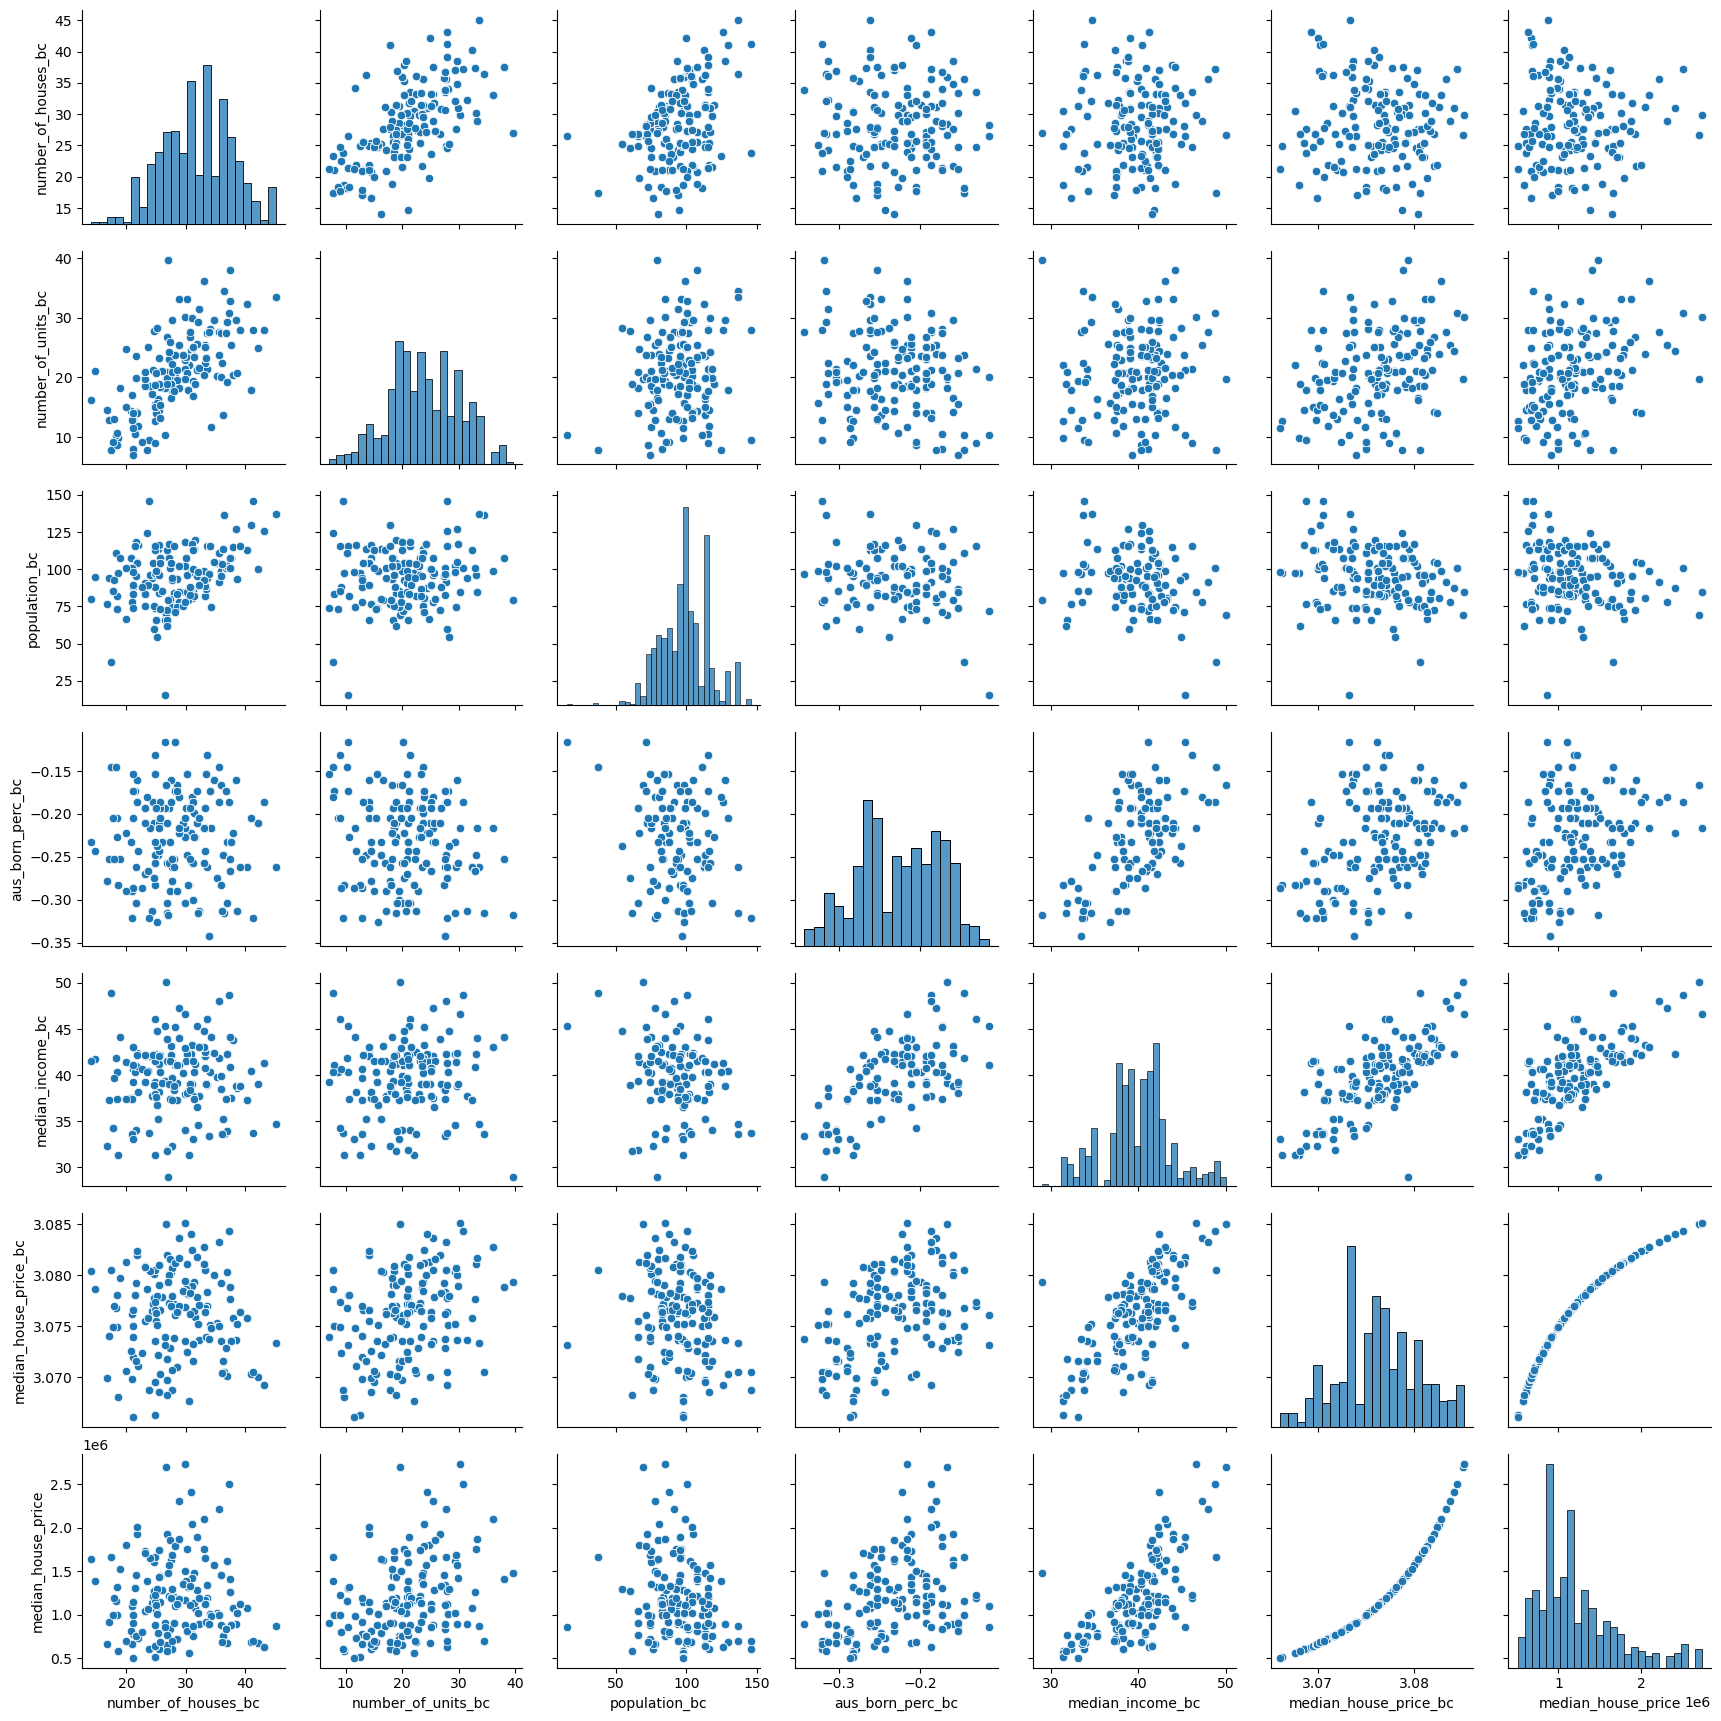

In [277]:
sns.pairplot(df[bc_cols])